<a href="https://colab.research.google.com/github/leaderman77/ai-challenge/blob/main/OntologyMappingEvaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AI Challenge: Trait Ontology Mapping**

**Executive Summary**

This report outlines a comprehensive solution for evaluating and improving gene-trait mappings generated by LLM models using a Trait Ontology (TO) vector database. Our approach combines traditional string matching techniques with modern NLP methods to ensure accurate trait identification and correction.

# 1. Data Understanding

**Input Data:** Three CSV files containing model outputs including trait_name and trait_id mappings

**Reference Data:** trait_ontology_details.txt containing official trait definitions, synonyms, and hierarchical relationships

**Data Structure:** Ontology entries include:

*   Trait id
*   Trait name
*   Definition
*   Synonyms
*   Hierarchical relationships ('is_a')
*   Obsolescence ('is_obsolete')

# Install required libraries

In [ ]:
!pip install rapidfuzz sentence-transformers torch rank-bm25 nltk scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.5 MB/s eta 0:00:00


# Import libraries

In [ ]:
# Standard Library Imports
import os
import re
from collections import Counter
from typing import Dict, List, Tuple, Set
from pathlib import Path

# NLP Libraries
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from difflib import SequenceMatcher
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Third-Party Library Imports
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
from dataclasses import dataclass
from transformers import AutoTokenizer, AutoModel

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sardo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


# Load models

In [ ]:
def load_model_responses(file_path):
    df = pd.read_csv(file_path)
    return df.drop_duplicates()

In [ ]:
model1_df = load_model_responses('response_model1.csv')
model2_df = load_model_responses('response_model2.csv')
model3_df = load_model_responses('response_model3.csv')

print("The lengths of model1: ", len(model1_df))
print("The lengths of model2: ", len(model2_df))
print("The lengths of model3: ", len(model3_df))

FileNotFoundError: [Errno 2] No such file or directory: 'response_model1.csv'

# Parsing the ontology file and structuring it into a dictionary format

In [ ]:
@dataclass
class OntologyTerm:
    """Data class to store information about an ontology term."""
    term_id: str
    name: str
    definition: str
    synonyms: List[str]
    is_a: List[str]
    is_obsolete: str

In [ ]:
class OntologyFileError(Exception):
    """Custom exception for ontology file-related errors."""
    pass

In [ ]:
def read_ontology_file(file_path: Path) -> str:
    try:
        with open(file_path, 'r') as file:
            return file.read()
    except (IOError, OSError) as e:
        raise OntologyFileError(f"Failed to read ontology file: {e}")

In [ ]:
def split_into_terms(content: str) -> List[str]:
    """
    Split the file content into individual term sections.
    """
    return [term for term in content.split('[Term]') if term.strip()]

In [ ]:
def extract_term_details(term_text: str) -> Dict:
    """
    Extract details from a single term section using regex.
    Returns:
        Dictionary containing extracted term details or None if required fields are missing
    """
    patterns = {
        'id': r'id: (TO:\d+)',
        'name': r'name: (.+)',
        'def': r'def: "(.+?)"',
        'synonym': r'synonym: "([^"]+)',
        'is_a': r'is_a: (.+)',
        'is_obsolete': r'is_obsolete: (.+)'
    }

    matches = {
        field: re.search(pattern, term_text) if field not in ['synonym', 'is_a']
        else re.findall(pattern, term_text)
        for field, pattern in patterns.items()
    }

    if not (matches['id'] and matches['name']):
        return None

    return OntologyTerm(
        term_id=matches['id'].group(1),
        name=matches['name'].group(1).strip(),
        definition=matches['def'].group(1).strip() if matches['def'] else '',
        synonyms=[syn.strip() for syn in matches['synonym']],
        is_a=[is_a.split(' ! ')[0].strip() for is_a in matches['is_a']],
        is_obsolete=matches['is_obsolete'].group(1).strip() if matches['is_obsolete'] else 'false'
    )

In [ ]:
def parse_ontology_file(file_path: str) -> Dict[str, OntologyTerm]:
    """
    Parse the trait ontology details file and return a dictionary with structured information.
    Returns:
        Dictionary mapping term IDs to OntologyTerm objects
    """
    try:
        file_path = Path(file_path)
        content = read_ontology_file(file_path)
        terms = split_into_terms(content)

        ontology_data = {}
        for term in terms:
            term_details = extract_term_details(term)
            if term_details:
                ontology_data[term_details.term_id] = term_details

        return ontology_data

    except Exception as e:
        raise OntologyFileError(f"Failed to parse ontology file: {e}")

In [ ]:
ontology_data = parse_ontology_file(r'C:\Users\sardo\Downloads\trait_ontology_details.txt')

# Displaying a snippet of the parsed ontology data
ontology_dict_snippet = {k: ontology_data[k] for k in list(ontology_data.keys())[:5]}
ontology_dict_snippet

{'TO:0000001': OntologyTerm(term_id='TO:0000001', name='carbon sensitivity', definition='Sensitivity to the carbon content in the growth medium. It plays an important role in the synthesis of various inorganic and organic metabolites such as carbohydrates, lipids, amino acids and peptides and plays a role in various metabolic processes.', synonyms=['carbon deficiency (related)', 'CBSN (related)'], is_a=['TO:0000252'], is_obsolete='false'),
 'TO:0000002': OntologyTerm(term_id='TO:0000002', name='OBSOLETE epigenetic trait', definition='OBSOLETE. An epigenetic trait is a distinguishable feature or a characteristic or a quality of character or a phenotypic feature of a developing or developed individual but have arisen as a result of mechanisms regulating the expression of the genes rather than differences in the gene sequence.', synonyms=[], is_a=[], is_obsolete='true'),
 'TO:0000003': OntologyTerm(term_id='TO:0000003', name='alkali soil sensitivity', definition='Plant sensitivity to soil

# Checking for duplicate IDs and names in the ontology data

In [ ]:
ontology_ids = list(ontology_data.keys())
ontology_names = [term.name for term in ontology_data.values()]

duplicate_ids = {term_id for term_id in ontology_ids if ontology_ids.count(term_id) > 1}
duplicate_names = {term_name for term_name in ontology_names if ontology_names.count(term_name) > 1}

duplicates_summary = {
    "Total IDs": len(ontology_ids),
    "Unique IDs": len(set(ontology_ids)),
    "Duplicate IDs": len(duplicate_ids),
    "Total Names": len(ontology_names),
    "Unique Names": len(set(ontology_names)),
    "Duplicate Names": len(duplicate_names),
}

duplicates_details = {
    "Duplicate IDs": list(duplicate_ids),
    "Duplicate Names": list(duplicate_names)
}

duplicates_summary, duplicates_details


({'Total IDs': 1667,
  'Unique IDs': 1667,
  'Duplicate IDs': 0,
  'Total Names': 1667,
  'Unique Names': 1667,
  'Duplicate Names': 0},
 {'Duplicate IDs': [], 'Duplicate Names': []})

# Explore the model response datasets

In [ ]:
def prepare_data_for_analysis():
    model1_df = load_model_responses('response_model1.csv')
    model2_df = load_model_responses('response_model2.csv')
    model3_df = load_model_responses('response_model3.csv')

    ontology_data = parse_ontology_file('trait_ontology_details.txt')

    return {
        'model1': model1_df,
        'model2': model2_df,
        'model3': model3_df,
        'ontology': ontology_data
    }

In [ ]:
def explore_loaded_data(data_dict):
    """
    Explore and visualize the loaded data from all sources
    """
    # Basic statistics for each model's data
    print("=== MODEL RESPONSE STATISTICS ===")
    for model_name in ['model1', 'model2', 'model3']:
        df = data_dict[model_name]
        print(f"\n{model_name.upper()}:")
        print(f"Total unique mappings: {len(df)}")
        print(f"Unique trait names: {df['trait_name'].nunique()}")
        print(f"Unique trait IDs: {df['trait_id'].nunique()}")

        print("\nMost common trait names:")
        print(df['trait_name'].value_counts().head(3))
        print("\nMost common trait IDs:")
        print(df['trait_id'].value_counts().head(3))

    # Ontology data exploration
    print("\n=== ONTOLOGY DATA STATISTICS ===")
    ontology = data_dict['ontology']
    print(f"Total number of terms in ontology: {len(ontology)}")

    # Compare trait IDs between models and ontology
    print("\n=== TRAIT ID COVERAGE ANALYSIS ===")
    ontology_ids = set(ontology.keys())
    for model_name in ['model1', 'model2', 'model3']:
        df = data_dict[model_name]
        model_ids = set(df['trait_id'])
        overlap = model_ids.intersection(ontology_ids)
        print(f"\n{model_name.upper()}:")
        print(f"Unique trait IDs: {len(model_ids)}")
        print(f"IDs found in ontology: {len(overlap)}")
        print(f"Coverage percentage: {(len(overlap)/len(model_ids))*100:.2f}%")

        # List a few IDs not found in ontology (if any)
        missing_ids = model_ids - ontology_ids
        if missing_ids:
            print("IDs not found in ontology:")
            print(list(missing_ids))

In [ ]:
data = prepare_data_for_analysis()
explore_loaded_data(data)

=== MODEL RESPONSE STATISTICS ===

MODEL1:
Total unique mappings: 113
Unique trait names: 61
Unique trait IDs: 52

Most common trait names:
trait_name
wheat powdery mildew disease resistance    10
drought tolerance                           6
wheat stripe rust disease resistance        5
Name: count, dtype: int64

Most common trait IDs:
trait_id
TO:0020061    10
TO:0000276     6
TO:0020055     6
Name: count, dtype: int64

MODEL2:
Total unique mappings: 104
Unique trait names: 37
Unique trait IDs: 27

Most common trait names:
trait_name
wheat stripe rust disease resistance       11
heading date                               10
wheat powdery mildew disease resistance    10
Name: count, dtype: int64

Most common trait IDs:
trait_id
TO:0020055    13
TO:0020061    10
TO:0000276    10
Name: count, dtype: int64

MODEL3:
Total unique mappings: 94
Unique trait names: 60
Unique trait IDs: 53

Most common trait names:
trait_name
thousand kernel weight    6
salt tolerance            6
stripe rust 

# Let's also see an example of matching and mismatching cases

In [ ]:
def analyze_matching_cases(data_dict, model_name):
    """
    Analyze some matching and potentially mismatching cases
    """
    print(f"\n=== MATCHING ANALYSIS FOR {model_name.upper()} ===")
    df = data_dict[model_name]
    ontology = data_dict['ontology']

    matching_cases = []
    mismatching_cases = []

    for _, row in df.head(10).iterrows():
        trait_id = row['trait_id']
        if trait_id in ontology:
            onto_name = ontology[trait_id].name
            if onto_name.lower() == row['trait_name'].lower():
                matching_cases.append((row['trait_name'], trait_id))
            else:
                mismatching_cases.append((row['trait_name'], trait_id, onto_name))

    print("\nExact matches found:")
    for name, id_ in matching_cases[:3]:
        print(f"Name: {name}, ID: {id_}")

    print("\nPotential mismatches found:")
    for model_name, id_, onto_name in mismatching_cases[:3]:
        print(f"Model name: {model_name}")
        print(f"Ontology name: {onto_name}")
        print(f"ID: {id_}\n")

In [ ]:
# Analyze matching cases for model1
analyze_matching_cases(data, 'model1')


=== MATCHING ANALYSIS FOR MODEL1 ===

Exact matches found:
Name: in vitro regeneration ability, ID: TO:0000243
Name: wheat stripe rust disease resistance, ID: TO:0020055
Name: grain yield trait, ID: TO:0000396

Potential mismatches found:
Model name: cytokinin accumulation
Ontology name: meristem tissue development trait
ID: TO:0006016

Model name: auxin response
Ontology name: meristem tissue development trait
ID: TO:0006016

Model name: nitrogen use efficiency
Ontology name: nitrogen recycling
ID: TO:0000506



In [ ]:
# Analyze matching cases for model2
analyze_matching_cases(data, 'model2')


=== MATCHING ANALYSIS FOR MODEL2 ===

Exact matches found:
Name: in vitro regeneration ability, ID: TO:0000243
Name: in vitro regeneration ability, ID: TO:0000243
Name: in vitro regeneration ability, ID: TO:0000243

Potential mismatches found:
Model name: nitrogen use efficiency
Ontology name: nitrogen recycling
ID: TO:0000506

Model name: abiotic stress tolerance
Ontology name: plant stress trait
ID: TO:0000164

Model name: abiotic stress tolerance
Ontology name: plant stress trait
ID: TO:0000164



In [ ]:
# Analyze matching cases for model3
analyze_matching_cases(data, 'model3')


=== MATCHING ANALYSIS FOR MODEL3 ===

Exact matches found:

Potential mismatches found:
Model name: plant regeneration
Ontology name: oligosaccharide content
ID: TO:0006003

Model name: cytokinin accumulation
Ontology name: inflorescence axis angle
ID: TO:0000270

Model name: nitrogen use efficiency
Ontology name: fungal disease response
ID: TO:0000439



# Task 1: Develop a Correctness Metric
**Goal:** Define a quantitative metric that evaluates the correctness of each row in the CSV files.

**Considerations:**
*   Does the **trait_name** correspond to the **trait_id** based on the **trait_ontology_details.txt**?
*   Partial matches or synonyms (if applicable).
*   Confidence in mapping correctness based on string similarity or semantic context (e.g., Levenshtein distance, embeddings).

**Matching Strategy**

I implemented a hierarchical matching system with multiple validation levels:

## Matching Metrics Comparison
| Order | Metric Name | Description |
|------------|------------|-------------|
| 1 | Exact Matching | Direct string comparison between model's trait_name and ontology's name field. Returns match only if strings are identical (case-insensitive). |
| 2 | Synonym & Partial Matching | Checks if model's trait_name exactly matches any term in ontology's synonyms field. If synonym matching fails, verifies if all words in model's trait_name exist in ontology's name field, allowing for subset matches (e.g., "grain yield" matches "grain yield trait"). |
| 3 | String Similarity Matching (SequenceMatcher) | Uses SequenceMatcher to calculate string similarity ratio between model's trait_name and ontology terms. Configurable threshold (typically 0.8) determines acceptance. |
| 4 | Semantic Matching with Mini LM L6 | Utilizes sentence-transformers/all-MiniLM-L6-v2 model to generate embeddings and compute cosine similarity. Considers contextual meaning rather than exact text. |
| 5 | Semantic Matching with BERT | Employs BERT-base model for semantic similarity computation. Generally provides more robust but computationally intensive semantic understanding. |
| 6 | Synonym Matching + Semantic Matching with Mini LM L6 | Combines synonym checking with MiniLM L6 semantic similarity. If synonym match fails, falls back to semantic matching. Provides balance between accuracy and efficiency. |
| 7 | Synonym Matching + Semantic Matching with BERT | Integrates synonym matching with BERT semantic analysis. Offers highest accuracy but requires more computational resources.|
| 8 | Ensemble Matcher | Combines multiple matching strategies (exact, synonym, partial, string similarity, and semantic) with weighted scoring. Provides robust results by leveraging strengths of each method and reducing reliance on any single approach. |

# Implementation

## Helper Functions

In [ ]:
def clean_text(text: str) -> str:
    return text.lower().strip()

In [ ]:
def get_words(text: str) -> set:
    """
    Convert text to a set of cleaned words.
    """
    return set(text.lower().strip().split())

In [ ]:
def is_word_match(model_words: Set[str], ontology_words: Set[str]) -> bool:
        """Check if all words in model_words exist in ontology_words."""
        return len(model_words) > 0 and model_words.issubset(ontology_words)

In [ ]:
def calculate_string_similarity(str1: str, str2: str) -> float:
    """
    Calculate string similarity using SequenceMatcher.
    Returns:
        Similarity score between 0 and 1
    """
    return SequenceMatcher(None, clean_text(str1), clean_text(str2)).ratio()

In [ ]:
def calculate_sklearn_semantic_similarity(emb1: np.ndarray, emb2: np.ndarray) -> float:
    """
    Calculate cosine similarity between embeddings.

    Args:
        emb1: First embedding vector
        emb2: Second embedding vector

    Returns:
        Cosine similarity score
    """
    from sklearn.metrics.pairwise import cosine_similarity

    return float(cosine_similarity(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0])

In [ ]:
def initialize_results_df(model_df: pd.DataFrame) -> pd.DataFrame:
    # Create a copy of input DataFrame to avoid modifications
    results_df = model_df.copy()

    results_df['match_type'] = ''
    results_df['match_score'] = 0.0
    results_df['ontology_name'] = ''
    results_df['matched_term'] = ''
    results_df['error_type'] = ''
    return results_df

In [ ]:
def calculate_summary_stats(results_df: pd.DataFrame) -> Dict:
    """
    Calculate summary statistics from evaluation results DataFrame.
    """
    total_pairs = len(results_df)

    match_counts = {
        'exact_matches': len(results_df[results_df['match_type']=='exact_match']),
        'synonym_matches': len(results_df[results_df['match_type']=='synonym_match']),
        'partial_matches': len(results_df[results_df['match_type']=='partial_match']),
        'similarity_matches': len(results_df[results_df['match_type']=='similarity_match']),
        'minilm_l6_semantic_match': len(results_df[results_df['match_type']=='minilm_l6_semantic_match']),
        'bert_semantic_match': len(results_df[results_df['match_type']=='bert_semantic_match']),
        'syn_minilm_semantic_match': len(results_df[results_df['match_type']=='syn_minilm_semantic_match']),
        'syn_bert_semantic_match': len(results_df[results_df['match_type']=='syn_bert_semantic_match']),
        'no_match': len(results_df[results_df['match_type']=='no_match']),
        'id_not_found': len(results_df[results_df['match_type'] == 'id_not_found'])
    }

    stats = {
        'total_pairs': total_pairs,
        'counts': match_counts
    }

    for match_type, count in match_counts.items():
        stats[f"{match_type}_percentage"] = (count / total_pairs) * 100

    score_columns = [
        'exact_match_score',
        'synonym_match_score',
        'partial_match_score',
        'similarity_match_score',
        'minilm_semantic_match_score',
        'bert_semantic_match_score',
        'syn_minilm_semantic_match_score',
        'syn_bert_semantic_match_score'
    ]

    for col in score_columns:
        if col in results_df.columns:
            stats[f"average_{col}"] = results_df[col].mean()

    return stats

In [ ]:
def analyze_model_matches(data_dict, evaluation_function, display_results_function):
    """
    Analyze matches for all models in the data dictionary using the specified evaluation function.

    Parameters:
        data_dict (dict): Dictionary containing data for models and ontology.
        evaluation_function (function): Function to evaluate matches (e.g., evaluate_exact_matches).
    """
    for model_name in ['model1', 'model2', 'model3']:
        results_df = evaluation_function(
            data_dict[model_name],
            data_dict['ontology']
        )
        summary_stats = calculate_summary_stats(results_df)
        display_results_function(model_name, results_df, summary_stats)

        # Store results back in data dictionary for future use
        data_dict[f'{model_name}_results'] = results_df
        data_dict[f'{model_name}_summary'] = summary_stats

## 1. Exact Matching

In [ ]:
def evaluate_exact_matches(model_df: pd.DataFrame, ontology_data: Dict) -> Tuple[pd.DataFrame, Dict]:
    """
    Evaluate exact matches between model predictions and ontology entries.

    Args:
        model_df: DataFrame containing trait_name and trait_id columns
        ontology_data: Dictionary containing ontology information

    Returns:
        Tuple containing:
        - DataFrame with match evaluation results
        # - Dictionary with summary statistics
    """
    results_df = initialize_results_df(model_df)

    for idx, row in results_df.iterrows():
        trait_id = row['trait_id']
        trait_name = row['trait_name'].lower().strip()

        if trait_id in ontology_data:
            ontology_name = ontology_data[trait_id].name.lower().strip()
            results_df.at[idx, 'ontology_name'] = ontology_data[trait_id].name

            if trait_name == ontology_name:
                results_df.at[idx, 'matched'] = True
                results_df.at[idx, 'match_type'] = 'exact_match'
                results_df.at[idx, 'match_score'] = 1.0
                results_df.at[idx, 'matched_term'] = ontology_name
            else:
                results_df.at[idx, 'matched'] = False
                # results_df.at[idx, 'match_status'] = 'no_match'
                results_df.at[idx, 'match_type'] = 'no_match'
                results_df.at[idx, 'match_score'] = 0.0
                results_df.at[idx, 'error_type'] = f"Name Mismatched. Expected: {ontology_name}"
        else:
            results_df.at[idx, 'matched'] = False
            results_df.at[idx, 'match_type'] = 'id_not_found'
            results_df.at[idx, 'error_type'] = 'ID not in ontology'
            results_df.at[idx, 'match_score'] = 0.0

    return results_df

In [ ]:
results_df = evaluate_exact_matches(
    data['model3'], data['ontology'])

selected_columns = ['trait_name', 'trait_id',
                    'match_type', 'match_score',
                    'ontology_name', 'matched_term',
                    'matched', 'error_type']
results_df = results_df[selected_columns]
results_df

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,plant regeneration,TO:0006003,no_match,0.0,oligosaccharide content,,False,Name Mismatched. Expected: oligosaccharide con...
1,cytokinin accumulation,TO:0000270,no_match,0.0,inflorescence axis angle,,False,Name Mismatched. Expected: inflorescence axis ...
2,nitrogen use efficiency,TO:0000439,no_match,0.0,fungal disease response,,False,Name Mismatched. Expected: fungal disease resp...
3,abiotic stress tolerance,TO:0000165,no_match,0.0,panicle inflorescence exsertion,,False,Name Mismatched. Expected: panicle inflorescen...
4,stripe rust resistance,TO:0006071,id_not_found,0.0,,,False,ID not in ontology
...,...,...,...,...,...,...,...,...
89,cereal cyst nematode resistance,TO:0006002,no_match,0.0,proline content,,False,Name Mismatched. Expected: proline content
90,heat stress tolerance,TO:0000274,no_match,0.0,spikelet floret morphology trait,,False,Name Mismatched. Expected: spikelet floret mor...
91,cell wall organization,TO:0006033,no_match,0.0,floret number per spikelet,,False,Name Mismatched. Expected: floret number per s...
92,pollen development,TO:0000254,no_match,0.0,growth media pH sensitivity,,False,Name Mismatched. Expected: growth media ph sen...


In [ ]:
results_df[results_df['matched']==False].head(10)

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,plant regeneration,TO:0006003,no_match,0.0,oligosaccharide content,,False,Name Mismatched. Expected: oligosaccharide con...
1,cytokinin accumulation,TO:0000270,no_match,0.0,inflorescence axis angle,,False,Name Mismatched. Expected: inflorescence axis ...
2,nitrogen use efficiency,TO:0000439,no_match,0.0,fungal disease response,,False,Name Mismatched. Expected: fungal disease resp...
3,abiotic stress tolerance,TO:0000165,no_match,0.0,panicle inflorescence exsertion,,False,Name Mismatched. Expected: panicle inflorescen...
4,stripe rust resistance,TO:0006071,id_not_found,0.0,,,False,ID not in ontology
5,septoria nodorum blotch susceptibility,TO:0006080,id_not_found,0.0,,,False,ID not in ontology
6,thousand kernel weight,TO:0000382,no_match,0.0,1000-grain weight,,False,Name Mismatched. Expected: 1000-grain weight
7,spike architecture,TO:0001110,no_match,0.0,spike inflorescence morphology trait,,False,Name Mismatched. Expected: spike inflorescence...
8,spike architecture,TO:0001110,no_match,0.0,spike inflorescence morphology trait,,False,Name Mismatched. Expected: spike inflorescence...
9,spike architecture,TO:0001110,no_match,0.0,spike inflorescence morphology trait,,False,Name Mismatched. Expected: spike inflorescence...


In [ ]:
def display_matching_results(model_name: str, results_df: pd.DataFrame, summary_stats: Dict):
    print(f"\n=== EXACT MATCHING RESULTS FOR {model_name.upper()} ===")
    print("\nSummary Statistics:")
    print(f"Total pairs evaluated: {summary_stats['total_pairs']}")

    print(f"Exact matches: {summary_stats['counts']['exact_matches']}")
    print(f"ID not found: {summary_stats['counts']['id_not_found']}")
    print(f"Name mismatches: {summary_stats['counts']['no_match']}")

    print("\nSample Results:")
    print("\nExact Matches (up to 3):")
    exact_matches = results_df[results_df['matched']==True].head(3)
    for _, row in exact_matches.iterrows():
        print(f"Trait Name: {row['trait_name']}")
        print(f"Trait ID: {row['trait_id']}\n")

    print("Mismatches (up to 3):")
    mismatches = results_df[results_df['matched']==False].head(3)
    for _, row in mismatches.iterrows():
        print(f"Trait Name: {row['trait_name']}")
        print(f"Trait ID: {row['trait_id']}")
        # print(f"Status: {row['match_status']}")
        print(f"Error: {row['error_type']}\n")

In [ ]:
analyze_model_matches(data, evaluate_exact_matches, display_matching_results)


=== EXACT MATCHING RESULTS FOR MODEL1 ===

Summary Statistics:
Total pairs evaluated: 113
Exact matches: 76
ID not found: 0
Name mismatches: 37

Sample Results:

Exact Matches (up to 3):
Trait Name: in vitro regeneration ability
Trait ID: TO:0000243

Trait Name: wheat stripe rust disease resistance
Trait ID: TO:0020055

Trait Name: grain yield trait
Trait ID: TO:0000396

Mismatches (up to 3):
Trait Name: cytokinin accumulation
Trait ID: TO:0006016
Error: Name Mismatched. Expected: meristem tissue development trait

Trait Name: auxin response
Trait ID: TO:0006016
Error: Name Mismatched. Expected: meristem tissue development trait

Trait Name: nitrogen use efficiency
Trait ID: TO:0000506
Error: Name Mismatched. Expected: nitrogen recycling


=== EXACT MATCHING RESULTS FOR MODEL2 ===

Summary Statistics:
Total pairs evaluated: 104
Exact matches: 56
ID not found: 0
Name mismatches: 48

Sample Results:

Exact Matches (up to 3):
Trait Name: in vitro regeneration ability
Trait ID: TO:0000243

## 2. Synonym & Partial Matching

In [ ]:
def evaluate_relaxed_matches(model_df: pd.DataFrame, ontology_data: Dict) -> Tuple[pd.DataFrame, Dict]:
    """
    Evaluate matches using word-based matching.

    Args:
        model_df: DataFrame containing trait_name and trait_id columns
        ontology_data: Dictionary containing ontology information

    Returns:
        Tuple of (results DataFrame, summary statistics)
    """
    results_df = initialize_results_df(model_df)
    for idx, row in results_df.iterrows():
        trait_id = row['trait_id']
        trait_name = clean_text(row['trait_name'])
        model_words = get_words(trait_name)

        # Handle missing IDs
        if trait_id not in ontology_data:
            results_df.at[idx, 'match_type'] = 'id_not_found'
            results_df.at[idx, 'error_type'] = 'ID not in ontology'
            results_df.at[idx, 'matched'] = False
            continue

        # Process ontology entry
        ontology_entry = ontology_data[trait_id]
        ontology_name = clean_text(ontology_entry.name)
        results_df.at[idx, 'ontology_name'] = ontology_entry.name

        # Check exact matches
        if trait_name == ontology_name:
            results_df.at[idx, 'match_type'] = 'exact_match'
            results_df.at[idx, 'match_score'] = 1.0
            results_df.at[idx, 'matched_term'] = ontology_entry.name
            results_df.at[idx, 'matched'] = True
            continue

        # Check synonym matches
        found_synonym = False
        for synonym in ontology_entry.synonyms:
            syn_term = clean_text(synonym.split(' (')[0])
            if trait_name == syn_term:
                results_df.at[idx, 'match_type'] = 'synonym_match'
                results_df.at[idx, 'match_score'] = 0.9
                results_df.at[idx, 'matched_term'] = synonym
                results_df.at[idx, 'matched'] = True
                found_synonym = True
                break

        if found_synonym:
            continue

        # Check for word-level matches with main name
        ontology_words = get_words(ontology_name)
        word_match = is_word_match(model_words, ontology_words)
        best_match = ontology_entry.name
        matching_source = 'main_name'

        # Check word-level matches with synonyms if main name didn't match
        if not word_match:
            for synonym in ontology_entry.synonyms:
                syn_term = synonym.split(' (')[0]
                syn_words = get_words(syn_term)
                if is_word_match(model_words, syn_words):
                    word_match = True
                    best_match = synonym
                    matching_source = 'synonym'
                    break

        if word_match:
            results_df.at[idx, 'match_type'] = 'partial_match'
            results_df.at[idx, 'match_score'] = 0.8
            results_df.at[idx, 'matched_term'] = best_match
            results_df.at[idx, 'matched'] = True
            results_df.at[idx, 'error_type'] = f"Word match {matching_source}: {best_match}"
        else:
            results_df.at[idx, 'match_type'] = 'no_match'
            results_df.at[idx, 'match_score'] = 0.0
            results_df.at[idx, 'matched'] = False
            results_df.at[idx, 'error_type'] = f"No word match with: {best_match}"

    return results_df

In [ ]:
results_df = evaluate_relaxed_matches(
    data['model1'], data['ontology'])

selected_columns = ['trait_name', 'trait_id',
                    'match_type', 'match_score',
                    'ontology_name', 'matched_term',
                    'matched', 'error_type']
results_df = results_df[selected_columns]
results_df

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,in vitro regeneration ability,TO:0000243,exact_match,1.0,in vitro regeneration ability,in vitro regeneration ability,True,
1,cytokinin accumulation,TO:0006016,no_match,0.0,meristem tissue development trait,,False,No word match with: meristem tissue developmen...
2,auxin response,TO:0006016,no_match,0.0,meristem tissue development trait,,False,No word match with: meristem tissue developmen...
3,nitrogen use efficiency,TO:0000506,no_match,0.0,nitrogen recycling,,False,No word match with: nitrogen recycling
4,nitrogen use efficiency,TO:0000506,no_match,0.0,nitrogen recycling,,False,No word match with: nitrogen recycling
...,...,...,...,...,...,...,...,...
108,cereal cyst nematode resistance,TO:0000384,no_match,0.0,nematode damage response trait,,False,No word match with: nematode damage response t...
109,heat tolerance,TO:0000259,exact_match,1.0,heat tolerance,heat tolerance,True,
110,heat tolerance,TO:0000259,exact_match,1.0,heat tolerance,heat tolerance,True,
111,heat tolerance,TO:0000259,exact_match,1.0,heat tolerance,heat tolerance,True,


In [ ]:
results_df[results_df['matched']==True].head(3)

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,in vitro regeneration ability,TO:0000243,exact_match,1.0,in vitro regeneration ability,in vitro regeneration ability,True,
5,abiotic stress tolerance,TO:0000168,synonym_match,0.9,abiotic plant stress trait,abiotic stress tolerance (related),True,
6,abiotic stress tolerance,TO:0000168,synonym_match,0.9,abiotic plant stress trait,abiotic stress tolerance (related),True,


In [ ]:
results_df[results_df['match_type']=='synonym_match']

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
5,abiotic stress tolerance,TO:0000168,synonym_match,0.9,abiotic plant stress trait,abiotic stress tolerance (related),True,
6,abiotic stress tolerance,TO:0000168,synonym_match,0.9,abiotic plant stress trait,abiotic stress tolerance (related),True,
64,abiotic stress tolerance,TO:0000168,synonym_match,0.9,abiotic plant stress trait,abiotic stress tolerance (related),True,


In [ ]:
results_df[results_df['match_type']=='partial_match']

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
36,grain yield,TO:0000396,partial_match,0.8,grain yield trait,grain yield trait,True,Word match main_name: grain yield trait
42,grain yield,TO:0000396,partial_match,0.8,grain yield trait,grain yield trait,True,Word match main_name: grain yield trait
69,cadmium content,TO:0006059,partial_match,0.8,cadmium content trait,cadmium content trait,True,Word match main_name: cadmium content trait
76,stripe rust disease resistance,TO:0020055,partial_match,0.8,wheat stripe rust disease resistance,wheat stripe rust disease resistance,True,Word match main_name: wheat stripe rust diseas...
94,photoperiod sensitivity,TO:0000229,partial_match,0.8,photoperiod sensitivity trait,photoperiod sensitivity trait,True,Word match main_name: photoperiod sensitivity ...


In [ ]:
def display_relaxed_matching_results(model_name: str, results_df: pd.DataFrame, summary_stats: Dict):
    """
    Display the results of exact matching evaluation in a readable format.
    """
    print(f"\n=== EXACT, SYNONYM & PARTIAL MATCHING RESULTS FOR {model_name.upper()} ===")
    print("\nSummary Statistics:")
    print(f"Total pairs evaluated: {summary_stats['total_pairs']}")

    print(f"Exact matches: {summary_stats['counts']['exact_matches']}")
    print(f"Synonym matches: {summary_stats['counts']['synonym_matches']}")
    print(f"Partial matches: {summary_stats['counts']['partial_matches']}")
    print(f"ID not found: {summary_stats['counts']['id_not_found']}")
    print(f"Name mismatches: {summary_stats['counts']['no_match']}")

    print("\nSample Results:")
    print("\nExact Matches (up to 3):")
    exact_matches = results_df[results_df['matched']==True].head(3)
    for _, row in exact_matches.iterrows():
        print(f"Trait Name: {row['trait_name']}")
        print(f"Trait ID: {row['trait_id']}")
        print(f"Match Type: {row['match_type']}\n")

    print("Mismatches (up to 3):")
    mismatches = results_df[results_df['matched']==False].head(3)
    for _, row in mismatches.iterrows():
        print(f"Trait Name: {row['trait_name']}")
        print(f"Trait ID: {row['trait_id']}")
        print(f"Status: {row['match_type']}")
        print(f"Error: {row['error_type']}\n")

In [ ]:
analyze_model_matches(data, evaluate_relaxed_matches, display_relaxed_matching_results)


=== EXACT, SYNONYM & PARTIAL MATCHING RESULTS FOR MODEL1 ===

Summary Statistics:
Total pairs evaluated: 113
Exact matches: 76
Synonym matches: 3
Partial matches: 5
ID not found: 0
Name mismatches: 29

Sample Results:

Exact Matches (up to 3):
Trait Name: in vitro regeneration ability
Trait ID: TO:0000243
Match Type: exact_match

Trait Name: abiotic stress tolerance
Trait ID: TO:0000168
Match Type: synonym_match

Trait Name: abiotic stress tolerance
Trait ID: TO:0000168
Match Type: synonym_match

Mismatches (up to 3):
Trait Name: cytokinin accumulation
Trait ID: TO:0006016
Status: no_match
Error: No word match with: meristem tissue development trait

Trait Name: auxin response
Trait ID: TO:0006016
Status: no_match
Error: No word match with: meristem tissue development trait

Trait Name: nitrogen use efficiency
Trait ID: TO:0000506
Status: no_match
Error: No word match with: nitrogen recycling


=== EXACT, SYNONYM & PARTIAL MATCHING RESULTS FOR MODEL2 ===

Summary Statistics:
Total pai

## 3. String Similarity Matching

In [ ]:
def evaluate_similarity_matches(
    model_df: pd.DataFrame,
    ontology_data: Dict,
    similarity_threshold: float = 0.8
) -> Tuple[pd.DataFrame, Dict]:
    """
    Evaluate matches using string similarity.

    Args:
        model_df: DataFrame containing trait_name and trait_id columns
        ontology_data: Dictionary containing ontology information
        similarity_threshold: Minimum similarity score for matches

    Returns:
        Tuple of (results DataFrame, summary statistics)
    """
    results_df = initialize_results_df(model_df)

    for idx, row in results_df.iterrows():
        trait_id = row['trait_id']
        trait_name = clean_text(row['trait_name'])

        # 1. Check for IDs
        if trait_id not in ontology_data:
            results_df.at[idx, 'match_type'] = 'id_not_found'
            results_df.at[idx, 'error_type'] = 'ID not in ontology'
            # match_counts['id_not_found'] += 1
            results_df.at[idx, 'matched'] = False
            continue

        # Process ontology entry
        ontology_entry = ontology_data[trait_id]
        ontology_name = clean_text(ontology_entry.name)
        results_df.at[idx, 'ontology_name'] = ontology_entry.name

        # 2. Check for exact match
        if trait_name == ontology_name:
            results_df.at[idx, 'match_type'] = 'exact_match'
            results_df.at[idx, 'matched'] = True
            results_df.at[idx, 'match_score'] = 1.0
            results_df.at[idx, 'matched_term'] = ontology_entry.name
            # match_counts['exact_matches'] += 1
            continue

        # 3. Check for synonym matches
        found_synonym = False
        for synonym in ontology_entry.synonyms:
            syn_term = clean_text(synonym.split(' (')[0])
            if trait_name == syn_term:
                results_df.at[idx, 'match_type'] = 'synonym_match'
                results_df.at[idx, 'match_score'] = 0.9
                results_df.at[idx, 'matched'] = True
                results_df.at[idx, 'matched_term'] = synonym
                # match_counts['synonym_matches'] += 1
                found_synonym = True
                break

        if found_synonym:
            continue

        # # 3. Check for word-level matches with main name
        # model_words = get_words(trait_name)
        # ontology_words = get_words(ontology_name)
        # word_match = is_word_match(model_words, ontology_words)
        # best_match = ontology_entry['name']
        # matching_source = 'main_name'

        # # 4. Check word-level matches with synonyms if main name didn't match
        # if not word_match:
        #     for synonym in ontology_entry['synonyms']:
        #         syn_term = synonym.split(' (')[0]
        #         syn_words = get_words(syn_term)
        #         if is_word_match(model_words, syn_words):
        #             word_match = True
        #             best_match = synonym
        #             matching_source = 'synonym'
        #             break

        # if word_match:
        #     results_df.at[idx, 'match_type'] = 'partial_match'
        #     results_df.at[idx, 'match_score'] = 0.9
        #     results_df.at[idx, 'matched_term'] = best_match
        #     results_df.at[idx, 'error_type'] = f"Word match ({matching_source}): {best_match}"
        #     match_counts['partial_matches'] += 1
        #     continue
        # else:
        #     results_df.at[idx, 'match_type'] = 'no_match'
        #     results_df.at[idx, 'match_score'] = 0.0
        #     results_df.at[idx, 'error_type'] = f"No word match with: {best_match}"
        #     match_counts['no_match'] += 1

        # Check similarity with main name
        similarity = calculate_string_similarity(trait_name, ontology_name)
        max_similarity = round(similarity, 2)
        best_match = ontology_entry.name

        # 6. Check partial matches with synonyms
        for synonym in ontology_entry.synonyms:
            syn_term = synonym.split(' (')[0]
            syn_similarity = calculate_string_similarity(trait_name, syn_term)
            syn_similarity = round(syn_similarity, 2)
            if syn_similarity > max_similarity:
                max_similarity = syn_similarity
                best_match = synonym

        # 7. Determine match type based on word match and similarity
        if max_similarity >= similarity_threshold:
            results_df.at[idx, 'match_type'] = 'similarity_match'
            results_df.at[idx, 'matched'] = True
            results_df.at[idx, 'match_score'] = max_similarity
            results_df.at[idx, 'matched_term'] = best_match
            results_df.at[idx, 'error_type'] = f"Similarity match with: {best_match}"
            # match_counts['partial_matches'] += 1
        else:
            results_df.at[idx, 'match_type'] = 'similarity_match'
            results_df.at[idx, 'matched'] = False
            results_df.at[idx, 'match_score'] = max_similarity
            results_df.at[idx, 'error_type'] = f"Below threshold ({max_similarity:.2f}): {best_match}"
            # match_counts['no_match'] += 1
    # summary_stats = calculate_summary_stats(match_counts, len(results_df))
    # summary_stats['string_similarity_threshold'] = similarity_threshold

    return results_df

In [ ]:
results_df = evaluate_similarity_matches(
    data['model1'], data['ontology'])

selected_columns = ['trait_name', 'trait_id',
                    'match_type', 'match_score',
                    'ontology_name', 'matched_term',
                    'matched', 'error_type']
results_df = results_df[selected_columns]
results_df.head(40)

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,in vitro regeneration ability,TO:0000243,exact_match,1.00,in vitro regeneration ability,in vitro regeneration ability,True,
1,cytokinin accumulation,TO:0006016,similarity_match,0.22,meristem tissue development trait,,False,Below threshold (0.22): meristem tissue develo...
2,auxin response,TO:0006016,similarity_match,0.09,meristem tissue development trait,,False,Below threshold (0.09): meristem tissue develo...
3,nitrogen use efficiency,TO:0000506,similarity_match,0.59,nitrogen recycling,,False,Below threshold (0.59): nitrogen recycling
4,nitrogen use efficiency,TO:0000506,similarity_match,0.59,nitrogen recycling,,False,Below threshold (0.59): nitrogen recycling
5,abiotic stress tolerance,TO:0000168,synonym_match,0.90,abiotic plant stress trait,abiotic stress tolerance (related),True,
6,abiotic stress tolerance,TO:0000168,synonym_match,0.90,abiotic plant stress trait,abiotic stress tolerance (related),True,
7,wheat stripe rust disease resistance,TO:0020055,exact_match,1.00,wheat stripe rust disease resistance,wheat stripe rust disease resistance,True,
8,septoria nodorum blotch disease resistance,TO:0020065,similarity_match,0.80,wheat septoria leaf blotch disease resistance,wheat septoria leaf blotch disease resistance,True,Similarity match with: wheat septoria leaf blo...
9,grain yield trait,TO:0000396,exact_match,1.00,grain yield trait,grain yield trait,True,


In [ ]:
results_df[results_df['match_type']=='partial_match']

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type


In [ ]:
def display_similarity_matching_results(model_name: str, results_df: pd.DataFrame, summary_stats: Dict):
    """
    Display the results of exact matching evaluation in a readable format.
    """
    print(f"\n=== EXACT, SYNONYM & SIMILARITY MATCHING RESULTS FOR {model_name.upper()} ===")
    print("\nSummary Statistics:")
    print(f"Total pairs evaluated: {summary_stats['total_pairs']}")
    # print(f"Similarity Threshold: {summary_stats['string_similarity_threshold']}")

    print(f"Exact matches: {summary_stats['counts']['exact_matches']}")
    print(f"Synonym matches: {summary_stats['counts']['synonym_matches']}")
    print(f"Similarity matches: {summary_stats['counts']['partial_matches']}")
    print(f"ID not found: {summary_stats['counts']['id_not_found']}")
    print(f"Name mismatches: {summary_stats['counts']['no_match']}")

In [ ]:
# Call with exact matches
analyze_model_matches(data, evaluate_relaxed_matches, display_similarity_matching_results)


=== EXACT, SYNONYM & SIMILARITY MATCHING RESULTS FOR MODEL1 ===

Summary Statistics:
Total pairs evaluated: 113
Exact matches: 76
Synonym matches: 3
Similarity matches: 5
ID not found: 0
Name mismatches: 29

=== EXACT, SYNONYM & SIMILARITY MATCHING RESULTS FOR MODEL2 ===

Summary Statistics:
Total pairs evaluated: 104
Exact matches: 56
Synonym matches: 9
Similarity matches: 11
ID not found: 0
Name mismatches: 28

=== EXACT, SYNONYM & SIMILARITY MATCHING RESULTS FOR MODEL3 ===

Summary Statistics:
Total pairs evaluated: 94
Exact matches: 14
Synonym matches: 0
Similarity matches: 2
ID not found: 4
Name mismatches: 74


## 4. Semantic Matching with Mini LM L6

In [ ]:
def evaluate_minilm_semantic_matches(
    model_df: pd.DataFrame,
    ontology_data: Dict,
    model_name: str = 'all-MiniLM-L6-v2',
    semantic_threshold: float = 0.80
) -> Tuple[pd.DataFrame, Dict]:
    """
    Evaluate matches using semantic similarity with embeddings.

    Args:
        model_df: DataFrame containing trait_name and trait_id columns
        ontology_data: Dictionary containing ontology information
        model_name: Name of the sentence transformer model
        semantic_threshold: Minimum semantic similarity score for matches

    Returns:
        Tuple of (results DataFrame, summary statistics)
    """
    try:
        model = SentenceTransformer(model_name)
    except Exception as e:
        raise Exception(f"Failed to load model {model_name}: {str(e)}")

    def get_embeddings(texts: List[str]) -> np.ndarray:
        """Get embeddings for a list of texts."""
        return model.encode(texts, convert_to_tensor=True, show_progress_bar=False).cpu().numpy()

    results_df = initialize_results_df(model_df)
    results_df['semantic_similarity'] = 0.0

    # Evaluate each trait name-id pair
    for idx, row in results_df.iterrows():
        trait_id = row['trait_id']
        trait_name = clean_text(row['trait_name'])

        # Check for IDs
        if trait_id not in ontology_data:
            results_df.at[idx, 'match_type'] = 'id_not_found'
            results_df.at[idx, 'error_type'] = 'ID not in ontology'
            # match_counts['id_not_found'] += 1
            results_df.at[idx, 'matched'] = False
            continue

        # Process ontology entry
        ontology_entry = ontology_data[trait_id]
        ontology_name = clean_text(ontology_entry.name)
        results_df.at[idx, 'ontology_name'] = ontology_entry.name

        # Check for exact match
        if trait_name == ontology_name:
            results_df.at[idx, 'match_type'] = 'exact_match'
            results_df.at[idx, 'matched'] = True
            results_df.at[idx, 'match_score'] = 1.00
            results_df.at[idx, 'matched_term'] = ontology_entry.name
            # match_counts['exact_matches'] += 1
            continue

        # Calculate semantic similarity with main name
        trait_emb = get_embeddings([trait_name])[0]
        ontology_emb = get_embeddings([ontology_name])[0]
        max_similarity = calculate_sklearn_semantic_similarity(trait_emb, ontology_emb)
        max_similarity = round(max_similarity, 2)
        best_match = ontology_entry.name
        matching_source = 'main_name'

        # Add definition to context if available
        if ontology_entry.definition:
            context_text = f"{ontology_name}. {ontology_entry.definition}. {ontology_entry.synonyms}"
            context_emb = get_embeddings([context_text])[0]
            context_similarity = calculate_sklearn_semantic_similarity(trait_emb, context_emb)
            context_similarity = round(context_similarity, 2)

            if context_similarity > max_similarity:
                max_similarity = context_similarity
                matching_source = 'main_name_with_context'

        # Store semantic similarity score
        results_df.at[idx, 'semantic_similarity'] = max_similarity

        # Assign match type based on similarity
        if max_similarity >= semantic_threshold:
            results_df.at[idx, 'match_type'] = 'minilm_l6_semantic_match'
            results_df.at[idx, 'matched'] = True
            results_df.at[idx, 'match_score'] = max_similarity
            results_df.at[idx, 'matched_term'] = best_match
            results_df.at[idx, 'error_type'] = f"Semantic match ({matching_source}): {best_match}"
            # match_counts['semantic_matches'] += 1
        else:
            results_df.at[idx, 'match_type'] = 'minilm_l6_semantic_match'
            results_df.at[idx, 'match_score'] = max_similarity
            results_df.at[idx, 'matched'] = False
            results_df.at[idx, 'error_type'] = f"Below threshold ({max_similarity:.2f}): {best_match}"
            # match_counts['no_match'] += 1

    return results_df

In [ ]:
results_df = evaluate_minilm_semantic_matches(
    data['model1'], data['ontology'])

selected_columns = ['trait_name', 'trait_id',
                    'match_type', 'match_score',
                    'ontology_name', 'matched_term',
                    'matched', 'error_type']
results_df = results_df[selected_columns]
results_df.head(40)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,in vitro regeneration ability,TO:0000243,exact_match,1.00,in vitro regeneration ability,in vitro regeneration ability,True,
1,cytokinin accumulation,TO:0006016,minilm_l6_semantic_match,0.19,meristem tissue development trait,,False,Below threshold (0.19): meristem tissue develo...
2,auxin response,TO:0006016,minilm_l6_semantic_match,0.16,meristem tissue development trait,,False,Below threshold (0.16): meristem tissue develo...
3,nitrogen use efficiency,TO:0000506,minilm_l6_semantic_match,0.74,nitrogen recycling,,False,Below threshold (0.74): nitrogen recycling
4,nitrogen use efficiency,TO:0000506,minilm_l6_semantic_match,0.74,nitrogen recycling,,False,Below threshold (0.74): nitrogen recycling
5,abiotic stress tolerance,TO:0000168,minilm_l6_semantic_match,0.77,abiotic plant stress trait,,False,Below threshold (0.77): abiotic plant stress t...
6,abiotic stress tolerance,TO:0000168,minilm_l6_semantic_match,0.77,abiotic plant stress trait,,False,Below threshold (0.77): abiotic plant stress t...
7,wheat stripe rust disease resistance,TO:0020055,exact_match,1.00,wheat stripe rust disease resistance,wheat stripe rust disease resistance,True,
8,septoria nodorum blotch disease resistance,TO:0020065,minilm_l6_semantic_match,0.82,wheat septoria leaf blotch disease resistance,wheat septoria leaf blotch disease resistance,True,Semantic match (main_name): wheat septoria lea...
9,grain yield trait,TO:0000396,exact_match,1.00,grain yield trait,grain yield trait,True,


In [ ]:
results_df[(results_df['match_type']=='minilm_l6_semantic_match') & (results_df['match_score']>=0.8)]

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
8,septoria nodorum blotch disease resistance,TO:0020065,minilm_l6_semantic_match,0.82,wheat septoria leaf blotch disease resistance,wheat septoria leaf blotch disease resistance,True,Semantic match (main_name): wheat septoria lea...
36,grain yield,TO:0000396,minilm_l6_semantic_match,0.85,grain yield trait,grain yield trait,True,Semantic match (main_name): grain yield trait
42,grain yield,TO:0000396,minilm_l6_semantic_match,0.85,grain yield trait,grain yield trait,True,Semantic match (main_name): grain yield trait
49,plant stress response,TO:0000164,minilm_l6_semantic_match,0.87,plant stress trait,plant stress trait,True,Semantic match (main_name): plant stress trait
50,plant stress response,TO:0000164,minilm_l6_semantic_match,0.87,plant stress trait,plant stress trait,True,Semantic match (main_name): plant stress trait
69,cadmium content,TO:0006059,minilm_l6_semantic_match,0.88,cadmium content trait,cadmium content trait,True,Semantic match (main_name): cadmium content trait
76,stripe rust disease resistance,TO:0020055,minilm_l6_semantic_match,0.82,wheat stripe rust disease resistance,wheat stripe rust disease resistance,True,Semantic match (main_name): wheat stripe rust ...
90,Fusarium head blight disease resistance,TO:0000663,minilm_l6_semantic_match,0.90,wheat fusarium head blight resistance,wheat fusarium head blight resistance,True,Semantic match (main_name): wheat fusarium hea...
94,photoperiod sensitivity,TO:0000229,minilm_l6_semantic_match,0.90,photoperiod sensitivity trait,photoperiod sensitivity trait,True,Semantic match (main_name): photoperiod sensit...
96,seed vigor,TO:0000280,minilm_l6_semantic_match,0.93,seedling vigor,seedling vigor,True,Semantic match (main_name): seedling vigor


In [ ]:
def display_semantic_matching_results(model_name: str, results_df: pd.DataFrame, summary_stats: Dict):
    """
    Display the results of exact matching evaluation in a readable format.
    """
    print(f"\n=== EXACT & MINI LLM SEMANTIC MATCHING RESULTS FOR {model_name.upper()} ===")
    print("\nSummary Statistics:")
    print(f"Total pairs evaluated: {summary_stats['total_pairs']}")
    # print(f"Semantic Threshold: {summary_stats['string_similarity_threshold']}")

    print(f"Exact matches: {summary_stats['counts']['exact_matches']}")
    # print(f"Synonym matches: {summary_stats['counts']['synonym_matches']}")
    print(f"Mini LM semantic matches in total: {summary_stats['counts']['minilm_l6_semantic_match']}")
    print(f"Mini LM semantic matches >= Threshold (0.8): {len(results_df[(results_df['match_type']=='minilm_l6_semantic_match') & (results_df['match_score']>=0.8)])}")
    print(f"Mini LM semantic matches >= 0.9: {len(results_df[(results_df['match_type']=='minilm_l6_semantic_match') & (results_df['match_score']>=0.9)])}")
    print(f"Mini LM semantic matches < Threshold (0.8): {len(results_df[(results_df['match_type']=='minilm_l6_semantic_match') & (results_df['match_score']<0.8)])}")

    # print(f"BERT semantic matches: {summary_stats['counts']['bert_semantic_match']}")
    print(f"ID not found: {summary_stats['counts']['id_not_found']}")
    print(f"Name mismatches: {summary_stats['counts']['no_match']}")

# Call with exact matches
analyze_model_matches(data, evaluate_minilm_semantic_matches, display_semantic_matching_results)


=== EXACT & MINI LLM SEMANTIC MATCHING RESULTS FOR MODEL1 ===

Summary Statistics:
Total pairs evaluated: 113
Exact matches: 76
Mini LM semantic matches in total: 37
Mini LM semantic matches >= Threshold (0.8): 12
Mini LM semantic matches >= 0.9: 5
Mini LM semantic matches < Threshold (0.8): 25
ID not found: 0
Name mismatches: 0

=== EXACT & MINI LLM SEMANTIC MATCHING RESULTS FOR MODEL2 ===

Summary Statistics:
Total pairs evaluated: 104
Exact matches: 56
Mini LM semantic matches in total: 48
Mini LM semantic matches >= Threshold (0.8): 19
Mini LM semantic matches >= 0.9: 0
Mini LM semantic matches < Threshold (0.8): 29
ID not found: 0
Name mismatches: 0

=== EXACT & MINI LLM SEMANTIC MATCHING RESULTS FOR MODEL3 ===

Summary Statistics:
Total pairs evaluated: 94
Exact matches: 14
Mini LM semantic matches in total: 76
Mini LM semantic matches >= Threshold (0.8): 1
Mini LM semantic matches >= 0.9: 0
Mini LM semantic matches < Threshold (0.8): 75
ID not found: 4
Name mismatches: 0


## 5. Semantic Matching with BERT

In [ ]:
from torch.nn.functional import cosine_similarity

def get_bert_embeddings(texts, model_name='bert-base-uncased'):
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Tokenize texts
    encoded_input = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )

    # Get model embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Use [CLS] token embeddings
    sentence_embeddings = model_output.last_hidden_state[:, 0, :]

    # Normalize embeddings
    sentence_embeddings = torch.nn.functional.normalize(sentence_embeddings, p=2, dim=1)

    return sentence_embeddings

# Specific sentences
texts = [
    "grain yield",
    "grain yield trait"
]

# Get embeddings
embeddings = get_bert_embeddings(texts)

# Calculate cosine similarity
similarity = cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0))

print(f"Sentences being compared:")
print(f"1: '{texts[0]}'")
print(f"2: '{texts[1]}'")
print(f"\nCosine similarity score: {similarity.item():.4f}")

# You can also print the raw embeddings if needed
print(f"\nEmbedding shapes:")
print(f"First sentence: {embeddings[0].shape}")
print(f"Second sentence: {embeddings[1].shape}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Sentences being compared:
1: 'grain yield'
2: 'grain yield trait'

Cosine similarity score: 0.9362

Embedding shapes:
First sentence: torch.Size([768])
Second sentence: torch.Size([768])


In [ ]:
from torch.nn.functional import cosine_similarity

def evaluate_bert_semantic_matches(
    model_df: pd.DataFrame,
    ontology_data: Dict,
    model_name: str = 'bert-base-uncased',
    semantic_threshold: float = 0.80
) -> Tuple[pd.DataFrame, Dict]:
    """
    Evaluate matches using semantic similarity with embeddings.

    Args:
        model_df: DataFrame containing trait_name and trait_id columns
        ontology_data: Dictionary containing ontology information
        model_name: Name of the sentence transformer model
        semantic_threshold: Minimum semantic similarity score for matches

    Returns:
        Tuple of (results DataFrame, summary statistics)
    """
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()  # Set model to evaluation mode
    except Exception as e:
        raise Exception(f"Failed to load model {model_name}: {str(e)}")

    def get_embeddings(texts: List[str]) -> np.ndarray:
        """Get BERT embeddings for a list of texts."""
        # Tokenize texts
        encoded_input = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )

        # Get model embeddings
        with torch.no_grad():
            outputs = model(**encoded_input)
            # Use [CLS] token embeddings
            embeddings = outputs.last_hidden_state[:, 0, :]
            # Normalize embeddings
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

        return embeddings.cpu().numpy()

    def calculate_semantic_similarity(emb1: np.ndarray, emb2: np.ndarray) -> float:
        """Calculate cosine similarity between two embeddings."""
        return float(np.dot(emb1, emb2))

    results_df = initialize_results_df(model_df)
    results_df['semantic_similarity'] = 0.0

    match_counts = {
        'exact_matches': 0,
        'semantic_matches': 0,
        'no_match': 0,
        'id_not_found': 0
    }

    # Create progress bar for the entire process
    total_rows = len(results_df)
    progress_bar = tqdm(total=total_rows, desc="Processing traits", unit="trait")

    # Process in batches to improve efficiency
    batch_size = 32
    for start_idx in range(0, len(results_df), batch_size):
        batch_df = results_df.iloc[start_idx:start_idx + batch_size]

        # Evaluate each trait name-id pair
        for idx, row in results_df.iterrows():
            trait_id = row['trait_id']
            trait_name = clean_text(row['trait_name'])

            # Check for IDs
            if trait_id not in ontology_data:
                results_df.at[idx, 'match_type'] = 'id_not_found'
                results_df.at[idx, 'error_type'] = 'ID not in ontology'
                results_df.at[idx, 'matched'] = False
                continue

            # Process ontology entry
            ontology_entry = ontology_data[trait_id]
            ontology_name = clean_text(ontology_entry.name)
            results_df.at[idx, 'ontology_name'] = ontology_entry.name

            # Check for exact match
            if trait_name == ontology_name:
                results_df.at[idx, 'match_type'] = 'exact_match'
                results_df.at[idx, 'matched'] = True
                results_df.at[idx, 'match_score'] = 1.00
                results_df.at[idx, 'matched_term'] = ontology_entry.name
                continue

            # Calculate semantic similarity with main name
            trait_emb = get_embeddings([trait_name])[0]
            ontology_emb = get_embeddings([ontology_name])[0]
            max_similarity = calculate_semantic_similarity(trait_emb, ontology_emb)
            max_similarity = round(max_similarity, 2)
            best_match = ontology_entry.name
            matching_source = 'main_name'

            # Add definition to context if available
            if ontology_entry.definition:
                context_text = f"{ontology_name}. {ontology_entry.definition}. {ontology_entry.synonyms}"
                context_emb = get_embeddings([context_text])[0]
                context_similarity = calculate_semantic_similarity(trait_emb, context_emb)
                context_similarity = round(context_similarity, 2)

                if context_similarity > max_similarity:
                    max_similarity = context_similarity
                    matching_source = 'main_name_with_context'

            # Store semantic similarity score
            results_df.at[idx, 'semantic_similarity'] = max_similarity

            # Assign match type based on similarity
            if max_similarity >= semantic_threshold:
                results_df.at[idx, 'match_type'] = 'bert_semantic_match'
                results_df.at[idx, 'matched'] = True
                results_df.at[idx, 'match_score'] = max_similarity
                results_df.at[idx, 'matched_term'] = best_match
                results_df.at[idx, 'error_type'] = f"Semantic match ({matching_source}): {best_match}"
            else:
                results_df.at[idx, 'match_type'] = 'bert_semantic_match'
                results_df.at[idx, 'match_score'] = max_similarity
                results_df.at[idx, 'matched'] = False
                results_df.at[idx, 'error_type'] = f"Below threshold ({max_similarity:.2f}): {best_match}"

            progress_bar.update(1)

    progress_bar.close()

    return results_df

In [ ]:
results_df = evaluate_bert_semantic_matches(
    data['model1'], data['ontology'])

selected_columns = ['trait_name', 'trait_id',
                    'match_type', 'match_score',
                    'ontology_name', 'matched_term',
                    'matched', 'error_type']
results_df = results_df[selected_columns]
results_df.head(40)

Processing traits: 148trait [01:06,  2.22trait/s]


,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,in vitro regeneration ability,TO:0000243,exact_match,1.00,in vitro regeneration ability,in vitro regeneration ability,True,
1,cytokinin accumulation,TO:0006016,bert_semantic_match,0.78,meristem tissue development trait,,False,Below threshold (0.78): meristem tissue develo...
2,auxin response,TO:0006016,bert_semantic_match,0.93,meristem tissue development trait,meristem tissue development trait,True,Semantic match (main_name): meristem tissue de...
3,nitrogen use efficiency,TO:0000506,bert_semantic_match,0.92,nitrogen recycling,nitrogen recycling,True,Semantic match (main_name): nitrogen recycling
4,nitrogen use efficiency,TO:0000506,bert_semantic_match,0.92,nitrogen recycling,nitrogen recycling,True,Semantic match (main_name): nitrogen recycling
5,abiotic stress tolerance,TO:0000168,bert_semantic_match,0.93,abiotic plant stress trait,abiotic plant stress trait,True,Semantic match (main_name): abiotic plant stre...
6,abiotic stress tolerance,TO:0000168,bert_semantic_match,0.93,abiotic plant stress trait,abiotic plant stress trait,True,Semantic match (main_name): abiotic plant stre...
7,wheat stripe rust disease resistance,TO:0020055,exact_match,1.00,wheat stripe rust disease resistance,wheat stripe rust disease resistance,True,
8,septoria nodorum blotch disease resistance,TO:0020065,bert_semantic_match,0.95,wheat septoria leaf blotch disease resistance,wheat septoria leaf blotch disease resistance,True,Semantic match (main_name): wheat septoria lea...
9,grain yield trait,TO:0000396,exact_match,1.00,grain yield trait,grain yield trait,True,


In [ ]:
def display_semantic_matching_results(model_name: str, results_df: pd.DataFrame, summary_stats: Dict):
    """
    Display the results of exact matching evaluation in a readable format.
    """
    print(f"\n=== EXACT & BERT SEMANTIC MATCHING RESULTS FOR {model_name.upper()} ===")
    print("\nSummary Statistics:")
    print(f"Total pairs evaluated: {summary_stats['total_pairs']}")
    # print(f"Semantic Threshold: {summary_stats['string_similarity_threshold']}")

    print(f"Exact matches: {summary_stats['counts']['exact_matches']}")
    # print(f"Synonym matches: {summary_stats['counts']['synonym_matches']}")
    # print(f"Mini LM semantic matches: {summary_stats['counts']['minilm_l6_semantic_match']}")
    print(f"BERT semantic matches in total: {summary_stats['counts']['bert_semantic_match']}")
    print(f"BERT semantic matches >= Threshold (0.8): {len(results_df[(results_df['match_type']=='bert_semantic_match') & (results_df['match_score']>=0.8)])}")
    print(f"BERT semantic matches >= 0.9: {len(results_df[(results_df['match_type']=='bert_semantic_match') & (results_df['match_score']>=0.9)])}")
    print(f"BERT semantic matches < Threshold (0.8): {len(results_df[(results_df['match_type']=='bert_semantic_match') & (results_df['match_score']<0.8)])}")
    print(f"ID not found: {summary_stats['counts']['id_not_found']}")
    print(f"Name mismatches: {summary_stats['counts']['no_match']}")

# Call with exact matches
analyze_model_matches(data, evaluate_bert_semantic_matches, display_semantic_matching_results)

Processing traits: 148trait [01:10,  2.11trait/s]



=== EXACT & BERT SEMANTIC MATCHING RESULTS FOR MODEL1 ===

Summary Statistics:
Total pairs evaluated: 113
Exact matches: 76
BERT semantic matches in total: 37
BERT semantic matches >= Threshold (0.8): 36
BERT semantic matches >= 0.9: 26
BERT semantic matches < Threshold (0.8): 1
ID not found: 0
Name mismatches: 0


Processing traits: 192trait [01:26,  2.21trait/s]



=== EXACT & BERT SEMANTIC MATCHING RESULTS FOR MODEL2 ===

Summary Statistics:
Total pairs evaluated: 104
Exact matches: 56
BERT semantic matches in total: 48
BERT semantic matches >= Threshold (0.8): 47
BERT semantic matches >= 0.9: 36
BERT semantic matches < Threshold (0.8): 1
ID not found: 0
Name mismatches: 0


Processing traits: 228trait [01:32,  2.46trait/s]


=== EXACT & BERT SEMANTIC MATCHING RESULTS FOR MODEL3 ===

Summary Statistics:
Total pairs evaluated: 94
Exact matches: 14
BERT semantic matches in total: 76
BERT semantic matches >= Threshold (0.8): 59
BERT semantic matches >= 0.9: 21
BERT semantic matches < Threshold (0.8): 17
ID not found: 4
Name mismatches: 0


## 6. Synonym Matching + Semantic Matching with Mini LM L6

In [ ]:
def eval_minilm_syn_semantic_matches(
    model_df: pd.DataFrame,
    ontology_data: Dict,
    model_name: str = 'all-MiniLM-L6-v2',
    semantic_threshold: float = 0.80
) -> Tuple[pd.DataFrame, Dict]:
    """
    Evaluate matches using semantic similarity with embeddings.

    Args:
        model_df: DataFrame containing trait_name and trait_id columns
        ontology_data: Dictionary containing ontology information
        model_name: Name of the sentence transformer model
        semantic_threshold: Minimum semantic similarity score for matches

    Returns:
        Tuple of (results DataFrame, summary statistics)
    """
    try:
        model = SentenceTransformer(model_name)
    except Exception as e:
        raise Exception(f"Failed to load model {model_name}: {str(e)}")

    def get_embeddings(texts: List[str]) -> np.ndarray:
        """Get embeddings for a list of texts."""
        return model.encode(texts, convert_to_tensor=True, show_progress_bar=False).cpu().numpy()

    results_df = initialize_results_df(model_df)
    results_df['semantic_similarity'] = 0.0

    # Evaluate each trait name-id pair
    for idx, row in results_df.iterrows():
        trait_id = row['trait_id']
        trait_name = clean_text(row['trait_name'])

        # Check for IDs
        if trait_id not in ontology_data:
            results_df.at[idx, 'match_type'] = 'id_not_found'
            results_df.at[idx, 'error_type'] = 'ID not in ontology'
            results_df.at[idx, 'matched'] = False
            continue

        # Process ontology entry
        ontology_entry = ontology_data[trait_id]
        ontology_name = clean_text(ontology_entry.name)
        results_df.at[idx, 'ontology_name'] = ontology_entry.name

        # Check for exact match
        if trait_name == ontology_name:
            results_df.at[idx, 'match_type'] = 'exact_match'
            results_df.at[idx, 'matched'] = True
            results_df.at[idx, 'match_score'] = 1.0
            results_df.at[idx, 'matched_term'] = ontology_entry.name
            continue

        # Check for synonym matches
        found_synonym = False
        for synonym in ontology_entry.synonyms:
            syn_term = clean_text(synonym.split(' (')[0])
            if trait_name == syn_term:
                results_df.at[idx, 'match_type'] = 'synonym_match'
                results_df.at[idx, 'match_score'] = 0.9
                results_df.at[idx, 'matched'] = True
                results_df.at[idx, 'matched_term'] = synonym
                found_synonym = True
                break

        if found_synonym:
            continue

        # Calculate semantic similarity with main name
        trait_emb = get_embeddings([trait_name])[0]
        ontology_emb = get_embeddings([ontology_name])[0]
        max_similarity = calculate_sklearn_semantic_similarity(trait_emb, ontology_emb)
        max_similarity = round(max_similarity, 2)
        best_match = ontology_entry.name
        matching_source = 'main_name'

        # Add definition to context if available
        if ontology_entry.definition:
            context_text = f"{ontology_name}. {ontology_entry.definition}"
            context_emb = get_embeddings([context_text])[0]
            context_similarity = calculate_sklearn_semantic_similarity(trait_emb, context_emb)
            context_similarity = round(context_similarity, 2)
            if context_similarity > max_similarity:
                max_similarity = context_similarity
                matching_source = 'main_name_with_context'

        # Check semantic similarity with synonyms
        for synonym in ontology_entry.synonyms:
            syn_term = synonym.split(' (')[0]
            syn_emb = get_embeddings([syn_term])[0]
            syn_similarity = calculate_sklearn_semantic_similarity(trait_emb, syn_emb)
            syn_similarity = round(syn_similarity, 2)

            if syn_similarity > max_similarity:
                max_similarity = syn_similarity
                best_match = synonym
                matching_source = 'synonym'

        # Store semantic similarity score
        results_df.at[idx, 'semantic_similarity'] = max_similarity

        # Determine match type based on semantic similarity threshold
        if max_similarity >= semantic_threshold:
            results_df.at[idx, 'match_type'] = 'syn_minilm_semantic_match'
            results_df.at[idx, 'match_score'] = max_similarity
            results_df.at[idx, 'matched'] = True
            results_df.at[idx, 'matched_term'] = best_match
            results_df.at[idx, 'error_type'] = f"Semantic match ({matching_source}): {best_match}"
        else:
            results_df.at[idx, 'match_type'] = 'syn_minilm_semantic_match'
            results_df.at[idx, 'match_score'] = max_similarity
            results_df.at[idx, 'matched'] = False
            results_df.at[idx, 'error_type'] = f"Below threshold ({max_similarity:.2f}): {best_match}"

    return results_df

In [ ]:
def display_semantic_matching_results(model_name: str, results_df: pd.DataFrame, summary_stats: Dict):
    """
    Display the results of exact matching evaluation in a readable format.
    """
    print(f"\n=== EXACT & MINI LLM SEMANTIC MATCHING RESULTS FOR {model_name.upper()} ===")
    print("\nSummary Statistics:")
    print(f"Total pairs evaluated: {summary_stats['total_pairs']}")
    # print(f"Semantic Threshold: {summary_stats['string_similarity_threshold']}")

    print(f"Exact matches: {summary_stats['counts']['exact_matches']}")
    print(f"Synonym matches: {summary_stats['counts']['synonym_matches']}")
    print(f"Mini LM semantic matches in total: {summary_stats['counts']['syn_minilm_semantic_match']}")
    print(f"Mini LM semantic matches >= Threshold (0.8): {len(results_df[(results_df['match_type']=='syn_minilm_semantic_match') & (results_df['match_score']>=0.8)])}")
    print(f"Mini LM semantic matches < Threshold (0.8): {len(results_df[(results_df['match_type']=='syn_minilm_semantic_match') & (results_df['match_score']<0.8)])}")
    print(f"Mini LM semantic matches >= 0.9: {len(results_df[(results_df['match_type']=='syn_minilm_semantic_match') & (results_df['match_score']>=0.9)])}")

    print(f"ID not found: {summary_stats['counts']['id_not_found']}")
    print(f"Name mismatches: {summary_stats['counts']['no_match']}")

# Call with exact matches
analyze_model_matches(data, eval_minilm_syn_semantic_matches, display_semantic_matching_results)


=== EXACT & MINI LLM SEMANTIC MATCHING RESULTS FOR MODEL1 ===

Summary Statistics:
Total pairs evaluated: 113
Exact matches: 76
Synonym matches: 3
Mini LM semantic matches in total: 34
Mini LM semantic matches >= Threshold (0.8): 12
Mini LM semantic matches < Threshold (0.8): 22
Mini LM semantic matches >= 0.9: 5
ID not found: 0
Name mismatches: 0

=== EXACT & MINI LLM SEMANTIC MATCHING RESULTS FOR MODEL2 ===

Summary Statistics:
Total pairs evaluated: 104
Exact matches: 56
Synonym matches: 9
Mini LM semantic matches in total: 39
Mini LM semantic matches >= Threshold (0.8): 11
Mini LM semantic matches < Threshold (0.8): 28
Mini LM semantic matches >= 0.9: 0
ID not found: 0
Name mismatches: 0

=== EXACT & MINI LLM SEMANTIC MATCHING RESULTS FOR MODEL3 ===

Summary Statistics:
Total pairs evaluated: 94
Exact matches: 14
Synonym matches: 0
Mini LM semantic matches in total: 76
Mini LM semantic matches >= Threshold (0.8): 2
Mini LM semantic matches < Threshold (0.8): 74
Mini LM semantic ma

In [ ]:
results_df = eval_minilm_syn_semantic_matches(
    data['model1'], data['ontology'])

selected_columns = ['trait_name', 'trait_id',
                    'match_type', 'match_score',
                    'ontology_name', 'matched_term',
                    'matched', 'error_type']
results_df = results_df[selected_columns]
results_df.head(40)

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,in vitro regeneration ability,TO:0000243,exact_match,1.00,in vitro regeneration ability,in vitro regeneration ability,True,
1,cytokinin accumulation,TO:0006016,syn_minilm_semantic_match,0.19,meristem tissue development trait,,False,Below threshold (0.19): meristem tissue develo...
2,auxin response,TO:0006016,syn_minilm_semantic_match,0.16,meristem tissue development trait,,False,Below threshold (0.16): meristem tissue develo...
3,nitrogen use efficiency,TO:0000506,syn_minilm_semantic_match,0.74,nitrogen recycling,,False,Below threshold (0.74): nitrogen recycling
4,nitrogen use efficiency,TO:0000506,syn_minilm_semantic_match,0.74,nitrogen recycling,,False,Below threshold (0.74): nitrogen recycling
5,abiotic stress tolerance,TO:0000168,synonym_match,0.90,abiotic plant stress trait,abiotic stress tolerance (related),True,
6,abiotic stress tolerance,TO:0000168,synonym_match,0.90,abiotic plant stress trait,abiotic stress tolerance (related),True,
7,wheat stripe rust disease resistance,TO:0020055,exact_match,1.00,wheat stripe rust disease resistance,wheat stripe rust disease resistance,True,
8,septoria nodorum blotch disease resistance,TO:0020065,syn_minilm_semantic_match,0.82,wheat septoria leaf blotch disease resistance,wheat septoria leaf blotch disease resistance,True,Semantic match (main_name): wheat septoria lea...
9,grain yield trait,TO:0000396,exact_match,1.00,grain yield trait,grain yield trait,True,


## 7. Synonym Matching + Semantic Matching with BERT

In [ ]:
from torch.nn.functional import cosine_similarity

def eval_bert_syn_semantic_matches(
    model_df: pd.DataFrame,
    ontology_data: Dict,
    model_name: str = 'bert-base-uncased',
    semantic_threshold: float = 0.80
) -> Tuple[pd.DataFrame, Dict]:
    """
    Evaluate matches using semantic similarity with embeddings.

    Args:
        model_df: DataFrame containing trait_name and trait_id columns
        ontology_data: Dictionary containing ontology information
        model_name: Name of the sentence transformer model
        semantic_threshold: Minimum semantic similarity score for matches

    Returns:
        Tuple of (results DataFrame, summary statistics)
    """
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()  # Set model to evaluation mode
    except Exception as e:
        raise Exception(f"Failed to load model {model_name}: {str(e)}")

    def get_embeddings(texts: List[str]) -> np.ndarray:
        """Get BERT embeddings for a list of texts."""
        # Tokenize texts
        encoded_input = tokenizer(
            texts,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        )

        # Get model embeddings
        with torch.no_grad():
            outputs = model(**encoded_input)
            # Use [CLS] token embeddings
            embeddings = outputs.last_hidden_state[:, 0, :]
            # Normalize embeddings
            embeddings = torch.nn.functional.normalize(embeddings, p=2, dim=1)

        return embeddings.cpu().numpy()

    def calculate_semantic_similarity(emb1: np.ndarray, emb2: np.ndarray) -> float:
        """Calculate cosine similarity between two embeddings."""
        return float(np.dot(emb1, emb2))

    results_df = initialize_results_df(model_df)
    results_df['semantic_similarity'] = 0.0

    # Create progress bar for the entire process
    total_rows = len(results_df)
    progress_bar = tqdm(total=total_rows, desc="Processing traits", unit="trait")

    # Process in batches to improve efficiency
    batch_size = 32
    for start_idx in range(0, len(results_df), batch_size):
        batch_df = results_df.iloc[start_idx:start_idx + batch_size]

        # Evaluate each trait name-id pair
        for idx, row in results_df.iterrows():
            trait_id = row['trait_id']
            trait_name = clean_text(row['trait_name'])

            # Check for IDs
            if trait_id not in ontology_data:
                results_df.at[idx, 'match_type'] = 'id_not_found'
                results_df.at[idx, 'error_type'] = 'ID not in ontology'
                # match_counts['id_not_found'] += 1
                results_df.at[idx, 'matched'] = False
                continue

            # Process ontology entry
            ontology_entry = ontology_data[trait_id]
            ontology_name = clean_text(ontology_entry.name)
            results_df.at[idx, 'ontology_name'] = ontology_entry.name

            # Check for exact match
            if trait_name == ontology_name:
                results_df.at[idx, 'match_type'] = 'exact_match'
                results_df.at[idx, 'matched'] = True
                results_df.at[idx, 'match_score'] = 1.0
                results_df.at[idx, 'matched_term'] = ontology_entry.name
                continue

            # Check for synonym matches
            found_synonym = False
            for synonym in ontology_entry.synonyms:
                syn_term = clean_text(synonym.split(' (')[0])
                if trait_name == syn_term:
                    results_df.at[idx, 'match_type'] = 'synonym_match'
                    results_df.at[idx, 'match_score'] = 0.9
                    results_df.at[idx, 'matched'] = True
                    results_df.at[idx, 'matched_term'] = synonym
                    found_synonym = True
                    break

            if found_synonym:
                continue

            # Calculate semantic similarity with main name
            trait_emb = get_embeddings([trait_name])[0]
            ontology_emb = get_embeddings([ontology_name])[0]
            max_similarity = calculate_semantic_similarity(trait_emb, ontology_emb)
            max_similarity = round(max_similarity, 2)
            best_match = ontology_entry.name
            matching_source = 'main_name'

            # Add definition to context if available
            if ontology_entry.definition:
                context_text = f"{ontology_name}. {ontology_entry.definition}"
                context_emb = get_embeddings([context_text])[0]
                context_similarity = calculate_semantic_similarity(trait_emb, context_emb)
                context_similarity = round(context_similarity, 2)
                if context_similarity > max_similarity:
                    max_similarity = context_similarity
                    matching_source = 'main_name_with_context'

            # Check semantic similarity with synonyms
            for synonym in ontology_entry.synonyms:
                syn_term = synonym.split(' (')[0]
                syn_emb = get_embeddings([syn_term])[0]
                syn_similarity = calculate_semantic_similarity(trait_emb, syn_emb)
                syn_similarity = round(syn_similarity, 2)

                if syn_similarity > max_similarity:
                    max_similarity = syn_similarity
                    best_match = synonym
                    matching_source = 'synonym'

            # Store semantic similarity score
            results_df.at[idx, 'semantic_similarity'] = max_similarity

            # Determine match type based on semantic similarity threshold
            if max_similarity >= semantic_threshold:
                results_df.at[idx, 'match_type'] = 'syn_bert_semantic_match'
                results_df.at[idx, 'match_score'] = max_similarity
                results_df.at[idx, 'matched'] = True
                results_df.at[idx, 'matched_term'] = best_match
                results_df.at[idx, 'error_type'] = f"Semantic match ({matching_source}): {best_match}"
            else:
                results_df.at[idx, 'match_type'] = 'syn_bert_semantic_match'
                results_df.at[idx, 'match_score'] = max_similarity
                results_df.at[idx, 'matched'] = False
                results_df.at[idx, 'error_type'] = f"Below threshold ({max_similarity:.2f}): {best_match}"

            progress_bar.update(1)

        progress_bar.close()

    return results_df

In [ ]:
def display_semantic_matching_results(model_name: str, results_df: pd.DataFrame, summary_stats: Dict):
    """
    Display the results of exact matching evaluation in a readable format.
    """
    print(f"\n=== EXACT & BERT SEMANTIC MATCHING RESULTS FOR {model_name.upper()} ===")
    print("\nSummary Statistics:")
    print(f"Total pairs evaluated: {summary_stats['total_pairs']}")

    print(f"Exact matches: {summary_stats['counts']['exact_matches']}")
    print(f"Synonym matches: {summary_stats['counts']['synonym_matches']}")
    print(f"BERT semantic matches in total: {summary_stats['counts']['syn_bert_semantic_match']}")
    print(f"BERT semantic matches >= Threshold (0.8): {len(results_df[(results_df['match_type']=='syn_bert_semantic_match') & (results_df['match_score']>=0.8)])}")
    print(f"BERT semantic matches >= 0.9: {len(results_df[(results_df['match_type']=='syn_bert_semantic_match') & (results_df['match_score']>=0.9)])}")
    print(f"BERT semantic matches < Threshold (0.8): {len(results_df[(results_df['match_type']=='syn_bert_semantic_match') & (results_df['match_score']<0.8)])}")
    print(f"ID not found: {summary_stats['counts']['id_not_found']}")
    print(f"Name mismatches: {summary_stats['counts']['no_match']}")


analyze_model_matches(data, eval_bert_syn_semantic_matches, display_semantic_matching_results)

Processing traits:  30%|███       | 34/113 [00:16<00:37,  2.08trait/s]



=== EXACT & BERT SEMANTIC MATCHING RESULTS FOR MODEL1 ===

Summary Statistics:
Total pairs evaluated: 113
Exact matches: 76
Synonym matches: 3
BERT semantic matches in total: 34
BERT semantic matches >= Threshold (0.8): 33
BERT semantic matches >= 0.9: 23
BERT semantic matches < Threshold (0.8): 1
ID not found: 0
Name mismatches: 0


Processing traits:  38%|███▊      | 39/104 [00:21<00:35,  1.83trait/s]



=== EXACT & BERT SEMANTIC MATCHING RESULTS FOR MODEL2 ===

Summary Statistics:
Total pairs evaluated: 104
Exact matches: 56
Synonym matches: 9
BERT semantic matches in total: 39
BERT semantic matches >= Threshold (0.8): 38
BERT semantic matches >= 0.9: 27
BERT semantic matches < Threshold (0.8): 1
ID not found: 0
Name mismatches: 0


Processing traits:  81%|████████  | 76/94 [00:34<00:08,  2.20trait/s]



=== EXACT & BERT SEMANTIC MATCHING RESULTS FOR MODEL3 ===

Summary Statistics:
Total pairs evaluated: 94
Exact matches: 14
Synonym matches: 0
BERT semantic matches in total: 76
BERT semantic matches >= Threshold (0.8): 61
BERT semantic matches >= 0.9: 21
BERT semantic matches < Threshold (0.8): 15
ID not found: 4
Name mismatches: 0


In [ ]:
results_df = eval_bert_syn_semantic_matches(
    data['model3'], data['ontology'])

selected_columns = ['trait_name', 'trait_id',
                    'match_type', 'match_score',
                    'ontology_name', 'matched_term',
                    'matched', 'error_type']
results_df = results_df[selected_columns]
results_df.head(40)

Processing traits:  81%|████████  | 76/94 [00:34<00:08,  2.20trait/s]


,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,plant regeneration,TO:0006003,syn_bert_semantic_match,0.77,oligosaccharide content,,False,Below threshold (0.77): oligosaccharide content
1,cytokinin accumulation,TO:0000270,syn_bert_semantic_match,0.69,inflorescence axis angle,,False,Below threshold (0.69): inflorescence axis angle
2,nitrogen use efficiency,TO:0000439,syn_bert_semantic_match,0.86,fungal disease response,fungal disease response,True,Semantic match (main_name): fungal disease res...
3,abiotic stress tolerance,TO:0000165,syn_bert_semantic_match,0.79,panicle inflorescence exsertion,,False,Below threshold (0.79): panicle inflorescence ...
4,stripe rust resistance,TO:0006071,id_not_found,0.00,,,False,ID not in ontology
5,septoria nodorum blotch susceptibility,TO:0006080,id_not_found,0.00,,,False,ID not in ontology
6,thousand kernel weight,TO:0000382,syn_bert_semantic_match,0.98,1000-grain weight,thousand seed weight (related),True,Semantic match (synonym): thousand seed weight...
7,spike architecture,TO:0001110,syn_bert_semantic_match,0.87,spike inflorescence morphology trait,spike inflorescence morphology trait,True,Semantic match (main_name): spike inflorescenc...
8,spike architecture,TO:0001110,syn_bert_semantic_match,0.87,spike inflorescence morphology trait,spike inflorescence morphology trait,True,Semantic match (main_name): spike inflorescenc...
9,spike architecture,TO:0001110,syn_bert_semantic_match,0.87,spike inflorescence morphology trait,spike inflorescence morphology trait,True,Semantic match (main_name): spike inflorescenc...


In [ ]:
results_df[(results_df['match_type']=='syn_bert_semantic_match') & (results_df['match_score']<0.8)]

,trait_name,trait_id,match_type,match_score,ontology_name,matched_term,matched,error_type
0,plant regeneration,TO:0006003,syn_bert_semantic_match,0.77,oligosaccharide content,,False,Below threshold (0.77): oligosaccharide content
1,cytokinin accumulation,TO:0000270,syn_bert_semantic_match,0.69,inflorescence axis angle,,False,Below threshold (0.69): inflorescence axis angle
3,abiotic stress tolerance,TO:0000165,syn_bert_semantic_match,0.79,panicle inflorescence exsertion,,False,Below threshold (0.79): panicle inflorescence ...
23,JA-responsiveness,TO:0006004,syn_bert_semantic_match,0.79,raffinose content,,False,Below threshold (0.79): raffinose content
30,stigma length,TO:0000516,syn_bert_semantic_match,0.76,relative root length,,False,Below threshold (0.76): relative root length
39,immunotoxicity reduction,TO:0006002,syn_bert_semantic_match,0.78,proline content,,False,Below threshold (0.78): proline content
40,immunotoxicity reduction,TO:0006002,syn_bert_semantic_match,0.78,proline content,,False,Below threshold (0.78): proline content
41,powdery mildew resistance,TO:0006003,syn_bert_semantic_match,0.78,oligosaccharide content,,False,Below threshold (0.78): oligosaccharide content
43,phosphate starvation tolerance,TO:0006005,syn_bert_semantic_match,0.78,fructose content,,False,Below threshold (0.78): fructose content
46,glume pubescence,TO:0006003,syn_bert_semantic_match,0.71,oligosaccharide content,,False,Below threshold (0.71): oligosaccharide content


## 8. Ensemble Matcher

In [ ]:
def evaluate_ensemble_matches(
    original_df: pd.DataFrame,
    relaxed_df: pd.DataFrame,
    similarity_df: pd.DataFrame,
    minilm_semantic_df: pd.DataFrame,
    bert_semantic_df: pd.DataFrame,
    minilm_syn_semantic_df: pd.DataFrame,
    bert_syn_semantic_df: pd.DataFrame,
) -> pd.DataFrame:
    """
    Combine all metric results into a single DataFrame.
    Returns:
        DataFrame with combined metric scores
    """
    # Start with original DataFrame
    results_df = original_df.copy()

    # Add ontology name (should be same in all DataFrames)
    results_df['ontology_name'] = relaxed_df.ontology_name

    # Initialize score columns
    score_columns = [
        'exact_match_score',
        'synonym_match_score',
        'partial_match_score',
        'similarity_match_score',
        'minilm_semantic_match_score',
        'bert_semantic_match_score',
        'mini_syn_semantic_match_score',
        'bert_syn_semantic_match_score'
    ]
    for col in score_columns:
        results_df[col] = 0.0

    # Process relaxed matching scores
    mask_exact = relaxed_df['match_type'] == 'exact_match'
    mask_synonym = relaxed_df['match_type'] == 'synonym_match'
    mask_partial = relaxed_df['match_type'] == 'partial_match'

    results_df.loc[mask_exact, 'exact_match_score'] = 1.0
    results_df.loc[mask_synonym, 'synonym_match_score'] = relaxed_df.loc[mask_synonym, 'match_score']
    results_df.loc[mask_partial, 'partial_match_score'] = relaxed_df.loc[mask_partial, 'match_score']

    # Process similarity matching scores
    similarity_partial_mask = similarity_df['match_type'] == 'similarity_match'
    results_df.loc[similarity_partial_mask, 'similarity_match_score'] = \
        similarity_df.loc[similarity_partial_mask, 'match_score']

    # Process minilm-l6 semantic matching scores
    mini_semantic_match_mask = minilm_semantic_df['match_type'] == 'minilm_l6_semantic_match'
    results_df.loc[mini_semantic_match_mask, 'minilm_semantic_match_score'] = \
        minilm_semantic_df.loc[mini_semantic_match_mask, 'match_score']

    # Process semantic matching scores
    bert_semantic_match_mask = bert_semantic_df['match_type'] == 'bert_semantic_match'
    results_df.loc[bert_semantic_match_mask, 'bert_semantic_match_score'] = \
        bert_semantic_df.loc[bert_semantic_match_mask, 'match_score']

    mini_syn_semantic_match_mask = minilm_syn_semantic_df['match_type'] == 'syn_minilm_semantic_match'
    results_df.loc[mini_syn_semantic_match_mask, 'mini_syn_semantic_match_score'] = \
        minilm_syn_semantic_df.loc[mini_syn_semantic_match_mask, 'match_score']

    bert_syn_semantic_match_mask = bert_syn_semantic_df['match_type'] == 'syn_bert_semantic_match'
    results_df.loc[bert_syn_semantic_match_mask, 'bert_syn_semantic_match_score'] = \
        bert_syn_semantic_df.loc[bert_syn_semantic_match_mask, 'match_score']

    # Calculate final score as the highest score among all metrics
    results_df['final_score'] = results_df[score_columns].max(axis=1)

    return results_df

In [ ]:
# model1_relaxed_df = evaluate_relaxed_matches(data['model1'],
#                                                      data['ontology'])
# model1_similarity_df = evaluate_similarity_matches(data['model1'],
#                                                      data['ontology'])
# model1_minilm_semantic_df = evaluate_minilm_semantic_matches(data['model1'],
#                                                      data['ontology'])
# model1_bert_semantic_df = evaluate_bert_semantic_matches(data['model1'],
#                                                      data['ontology'])

# model1_mini_syn_semantic_df = eval_minilm_syn_semantic_matches(data['model1'],
#                                                      data['ontology'])

# model1_bert_syn_semantic_df = eval_bert_syn_semantic_matches(data['model1'],
#                                                      data['ontology'])

# model1_combined_df = evaluate_ensemble_matches(model1_df,
#                                                model1_relaxed_df,
#                                                model1_similarity_df,
#                                                model1_minilm_semantic_df,
#                                                model1_bert_semantic_df,
#                                                model1_mini_syn_semantic_df,
#                                                model1_bert_syn_semantic_df)

# selected_columns = ['trait_name', 'trait_id','ontology_name',
#        'exact_match_score', 'synonym_match_score', 'partial_match_score',
#        'similarity_match_score', 'minilm_semantic_match_score',
#        'bert_semantic_match_score', 'mini_syn_semantic_match_score',
#        'bert_syn_semantic_match_score', 'final_score']

# model1_combined_df = model1_combined_df[selected_columns]
# model1_combined_df.head(40)

In [ ]:
model1_relaxed_df = evaluate_relaxed_matches(data['model1'],
                                                     data['ontology'])
mask_partial = model1_relaxed_df['match_type'] == 'partial_match'
model1_relaxed_df.loc[mask_partial, 'match_score']

,match_score
36,0.8
42,0.8
69,0.8
76,0.8
94,0.8


In [ ]:
mask_synonym = model1_relaxed_df['match_type'] == 'synonym_match'

model1_relaxed_df.loc[mask_synonym, 'match_score']

,match_score
5,0.9
6,0.9
64,0.9


# Task 2: Rank CSVs Based on Correctness
**Goal:** Aggregate the correctness scores across rows and rank the 3 CSVs based on the overall quality of their mappings.

**Deliverable:** A ranked list of the files, supported by a brief explanation of your scoring methodology.

## Results Analysis
## Match Distribution & Error Analysis

| Match Type | Model1 | Model2 | Model3 |
|------------|----------------|----------------|---------------|
| **Dataset Size** |
| Total Entries | 113 | 104 | 94 |
| **Model Performance** |
| Accuracy | 99.12% | 99.04% | 79.79% |
| Average Final Score | 0.972 | 0.960 | 0.837 |
| **Basic Matching** |
| Exact Matches | 76 | 56 | 14 |
| Synonym Matches | 3 | 9 | 0 |
| Similarity Matches | 5 | 11 | 2 |
| Name Mismatches | 29 | 28 | 74 |
| ID Not Found | 0 | 0 | 4 |
| **Mini LM Semantic** |
| Total Semantic | 34 | 39 | 76 |
| Score ≥ 0.9 | 5 | 0 | 0 |
| Score ≥ 0.8 | 12 | 11 | 2 |
| Score < 0.8 | 22 | 28 | 74 |
| **BERT Semantic** |
| Total Semantic | 37 | 48 | 76 |
| Score ≥ 0.9 | 26 | 36 | 21 |
| Score ≥ 0.8 | 36 | 47 | 59 |
| Score < 0.8 | 1 | 1 | 17 |

### Key Insights:
1. **Performance Hierarchy**
  - Model1 shows superior performance with 99.12% accuracy and highest perfect match rate (67.3%)
  - Model2 closely follows with 99.04% accuracy and balanced matching distribution
  - Model3 shows significantly different patterns with 79.79% accuracy and heavy reliance on semantic matching
  - BERT semantic matching yields better high-confidence matches (≥0.9) compared to Mini LM
  - Only Model3 has ID not found cases (4 instances)

2. **Matching Patterns**
  - Clear trend of decreasing exact matches across models (67.3% → 53.8% → 14.9%)
  - Increasing dependency on semantic matching (32.7% → 46.2% → 80.9%)
  - Variable performance in synonym matching (2.7% → 8.7% → 0%)

3. **Quality Assessment**
  - Models 1 & 2 achieve excellent high-quality match rates (>99%)
  - Model3 shows more varied quality distribution with 16% medium-quality matches
  - Only Model3 has cases with no matches (4.3%)


In [ ]:
def evaluate_all_models(data: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Evaluate multiple models using different matching approaches and combine results.

    Args:
        data: Dictionary containing model DataFrames and ontology data
            Expected keys: 'model1', 'model2', 'model3', 'ontology'

    Returns:
        Dictionary containing combined results for each model
    """
    results = {}

    # Process each model
    for model_name in ['model1', 'model2', 'model3']:
        if model_name not in data:
            continue

        # Run all matching evaluations
        relaxed_df = evaluate_relaxed_matches(
            data[model_name],
            data['ontology']
        )

        similarity_df = evaluate_similarity_matches(
            data[model_name],
            data['ontology']
        )

        minilm_semantic_df = evaluate_minilm_semantic_matches(
            data[model_name],
            data['ontology']
        )

        bert_semantic_df = evaluate_bert_semantic_matches(
            data[model_name],
            data['ontology']
        )

        minilm_syn_semantic_df = eval_minilm_syn_semantic_matches(
            data[model_name],
            data['ontology']
        )

        bert_syn_semantic_df = eval_bert_syn_semantic_matches(
            data[model_name],
            data['ontology']
        )

        # Combine results for this model
        combined_df = evaluate_ensemble_matches(
            original_df=data[model_name],
            relaxed_df=relaxed_df,
            similarity_df=similarity_df,
            minilm_semantic_df=minilm_semantic_df,
            bert_semantic_df=bert_semantic_df,
            minilm_syn_semantic_df=minilm_syn_semantic_df,
            bert_syn_semantic_df=bert_syn_semantic_df,
        )

        results[model_name] = combined_df

    return results

In [ ]:
def rank_models(model_results: Dict[str, pd.DataFrame]) -> Tuple[pd.DataFrame, Dict]:
    """
    Rank models based on their mapping quality using multiple metrics.

    Args:
        model_results: Dictionary of DataFrames containing each model's results

    Returns:
        Tuple of (rankings DataFrame, detailed statistics dictionary)
    """
    rankings = {}
    detailed_stats = {}

    for model_name, results_df in model_results.items():
        # Calculate various quality metrics
        stats = {
            'average_score': results_df['final_score'].mean(),
            'perfect_matches': (results_df['final_score'] == 1.0).mean(),
            'high_quality_matches': (results_df['final_score'] >= 0.8).mean(),
            'medium_quality_matches': ((results_df['final_score'] >= 0.5) &
                                     (results_df['final_score'] < 0.8)).mean(),
            'low_quality_matches': ((results_df['final_score'] > 0) &
                                  (results_df['final_score'] < 0.5)).mean(),
            'no_matches': (results_df['final_score'] == 0).mean(),
            'exact_match_rate': (results_df['exact_match_score'] == 1.0).mean(),
            'synonym_match_rate': (results_df['synonym_match_score'] > 0).mean(),
            'partial_match_rate': (results_df['partial_match_score'] > 0).mean(),
            'mini_semantic_match_rate': (results_df['minilm_semantic_match_score'] > 0).mean(),
            'bert_semantic_match_rate': (results_df['bert_semantic_match_score'] > 0).mean(),
            'syn_mini_semantic_match_rate': (results_df['mini_syn_semantic_match_score'] > 0).mean(),
            'syn_bert_semantic_match_rate': (results_df['bert_syn_semantic_match_score'] > 0).mean()
        }

        # Calculate weighted quality score with normalized weights summing to 1.0
        quality_score = (
            stats['perfect_matches'] * 0.45 +  # Highest weight for perfect matches
            stats['high_quality_matches'] * 0.35 +  # Strong weight for high-quality matches
            stats['medium_quality_matches'] * 0.15 +  # Moderate weight for medium matches
            stats['low_quality_matches'] * 0.05  # Lowest weight for low-quality matches
        )

        stats['quality_score'] = quality_score
        rankings[model_name] = quality_score
        detailed_stats[model_name] = stats

    # Create rankings DataFrame
    rankings_df = pd.DataFrame.from_dict(rankings, orient='index',
                                       columns=['quality_score'])
    rankings_df = rankings_df.sort_values('quality_score', ascending=False)

    # Add ranks
    rankings_df['rank'] = range(1, len(rankings_df) + 1)

    return rankings_df, detailed_stats

In [ ]:
def generate_ranking_report(rankings_df: pd.DataFrame,
                          detailed_stats: Dict) -> str:
    """
    Generate a detailed report explaining the rankings.

    Args:
        rankings_df: DataFrame containing model rankings
        detailed_stats: Dictionary containing detailed statistics for each model

    Returns:
        Formatted report string
    """
    report = "Model Rankings and Analysis\n" + "="*50 + "\n\n"

    for model_name in rankings_df.index:
        rank = rankings_df.loc[model_name, 'rank']
        score = rankings_df.loc[model_name, 'quality_score']
        stats = detailed_stats[model_name]

        report += f"Rank #{rank}: {model_name}\n"
        report += f"Overall Quality Score: {score:.3f}\n\n"
        report += "Key Metrics:\n"
        report += f"- Perfect Matches: {stats['perfect_matches']:.1%}\n"
        report += f"- High-Quality Matches (≥0.8): {stats['high_quality_matches']:.1%}\n"
        report += f"- Medium-Quality Matches (0.5-0.8): {stats['medium_quality_matches']:.1%}\n"
        report += f"- Low-Quality Matches (<0.5): {stats['low_quality_matches']:.1%}\n"
        report += f"- No Matches: {stats['no_matches']:.1%}\n\n"
        report += "Match Type Distribution:\n"
        report += f"- Exact Matches: {stats['exact_match_rate']:.1%}\n"
        report += f"- Synonym Matches: {stats['synonym_match_rate']:.1%}\n"
        report += f"- Partial Matches: {stats['partial_match_rate']:.1%}\n"
        report += f"- Mini LM Semantic Matches: {stats['mini_semantic_match_rate']:.1%}\n"
        report += f"- BERT Semantic Matches: {stats['bert_semantic_match_rate']:.1%}\n"
        report += f"- Synonym + Mini LM Semantic Matches: {stats['syn_mini_semantic_match_rate']:.1%}\n"
        report += f"- Synonym + BERT Semantic Matches: {stats['syn_bert_semantic_match_rate']:.1%}\n"
        report += "-"*50 + "\n\n"

    return report

In [ ]:
def evaluate_and_rank_models():
    """Complete workflow for evaluating and ranking models."""

    # 2. Evaluate all models
    print("Evaluating models...")
    model_results = evaluate_all_models(data)

    # 3. Rank models
    print("\nCalculating rankings...")
    rankings_df, detailed_stats = rank_models(model_results)

    # 4. Generate report
    print("\nGenerating detailed report...")
    report = generate_ranking_report(rankings_df, detailed_stats)
    print(report)

    # 5. Print results
    print("Model Rankings:")
    print(rankings_df)
    print("\nDetailed Report:")
    print(report)

    # 6. Optional: Save detailed results for each model
    for model_name, results_df in model_results.items():
        results_df.to_csv(f'{model_name}_detailed_results.csv', index=False)

    return model_results, rankings_df, detailed_stats

In [ ]:
model_results = evaluate_and_rank_models()

Evaluating models...


Processing traits: 148trait [01:06,  2.21trait/s]
Processing traits:  30%|███       | 34/113 [00:18<00:42,  1.86trait/s]
Processing traits: 192trait [01:26,  2.23trait/s]
Processing traits:  38%|███▊      | 39/104 [00:20<00:34,  1.88trait/s]
Processing traits: 228trait [01:35,  2.38trait/s]
Processing traits:  81%|████████  | 76/94 [00:34<00:08,  2.17trait/s]



Calculating rankings...

Generating detailed report...
Model Rankings and Analysis

Rank #1: model1
Overall Quality Score: 0.651

Key Metrics:
- Perfect Matches: 67.3%
- High-Quality Matches (≥0.8): 99.1%
- Medium-Quality Matches (0.5-0.8): 0.9%
- Low-Quality Matches (<0.5): 0.0%
- No Matches: 0.0%

Match Type Distribution:
- Exact Matches: 67.3%
- Synonym Matches: 2.7%
- Partial Matches: 4.4%
- Mini LM Semantic Matches: 32.7%
- BERT Semantic Matches: 32.7%
- Synonym + Mini LM Semantic Matches: 30.1%
- Synonym + BERT Semantic Matches: 30.1%
--------------------------------------------------

Rank #2: model2
Overall Quality Score: 0.590

Key Metrics:
- Perfect Matches: 53.8%
- High-Quality Matches (≥0.8): 99.0%
- Medium-Quality Matches (0.5-0.8): 1.0%
- Low-Quality Matches (<0.5): 0.0%
- No Matches: 0.0%

Match Type Distribution:
- Exact Matches: 53.8%
- Synonym Matches: 8.7%
- Partial Matches: 10.6%
- Mini LM Semantic Matches: 46.2%
- BERT Semantic Matches: 46.2%
- Synonym + Mini LM S

In [ ]:
print("Evaluating models...")
model_results = evaluate_all_models(data)
# Example of accessing specific results
print("\nExample detailed results for Model 1:")
print(model_results['model1'][['trait_name', 'ontology_name', 'final_score']].head())

# Analyze results
for model_name, results_df in model_results.items():
    print(f"\nSummary statistics for {model_name}:")
    print(f"Model Length: {len(results_df)}")
    print(f"Average final score: {results_df['final_score'].mean():.3f}")
    print(f"Model Accuracy: {(results_df['final_score'] >= 0.8).sum()/len(results_df)}")
    print(f"Number of perfect matches: {(results_df['final_score'] == 1.0).sum()}")
    print(f"High-quality matches: {(results_df['final_score'] >= 0.8).sum()}")
    print(f"Total Matches when threshold => 0.8: {len(results_df[results_df['final_score'] >= 0.8])}")
    print(f"Total Missmatches when threshold < 0.8: {len(results_df[results_df['final_score'] < 0.8])}")

Evaluating models...


Processing traits: 148trait [01:07,  2.19trait/s]
Processing traits:  30%|███       | 34/113 [00:16<00:38,  2.06trait/s]
Processing traits: 192trait [01:25,  2.24trait/s]
Processing traits:  38%|███▊      | 39/104 [00:20<00:33,  1.95trait/s]
Processing traits: 228trait [01:35,  2.38trait/s]
Processing traits:  81%|████████  | 76/94 [00:36<00:08,  2.11trait/s]



Example detailed results for Model 1:
                      trait_name                      ontology_name  \
0  in vitro regeneration ability      in vitro regeneration ability   
1         cytokinin accumulation  meristem tissue development trait   
2                 auxin response  meristem tissue development trait   
3        nitrogen use efficiency                 nitrogen recycling   
4        nitrogen use efficiency                 nitrogen recycling   

   final_score  
0         1.00  
1         0.78  
2         0.93  
3         0.92  
4         0.92  

Summary statistics for model1:
Model Length: 113
Average final score: 0.972
Model Accuracy: 0.9911504424778761
Number of perfect matches: 76
High-quality matches: 112
Total Matches when threshold => 0.8: 112
Total Missmatches when threshold < 0.8: 1

Summary statistics for model2:
Model Length: 104
Average final score: 0.960
Model Accuracy: 0.9903846153846154
Number of perfect matches: 56
High-quality matches: 103
Total Matches

In [ ]:
model_results['model3']

,Unnamed: 0,pmid,gene,species,trait_name,trait_id,relation_type,evidence,method,ontology_name,exact_match_score,synonym_match_score,partial_match_score,similarity_match_score,minilm_semantic_match_score,bert_semantic_match_score,mini_syn_semantic_match_score,bert_syn_semantic_match_score,final_score
0,0,PMID:37897039,TaLAX PANICLE1,Triticum aestivum,plant regeneration,TO:0006003,enhances,Overexpression of TaLAX PANICLE1 (TaLAX1) mark...,gene overexpression,oligosaccharide content,0.0,0.0,0.0,0.34,0.24,0.77,0.25,0.77,0.77
1,1,PMID:37897039,TaGROWTH-REGULATING FACTOR,Triticum aestivum,cytokinin accumulation,TO:0000270,enhances,Increased expression of TaGROWTH-REGULATING FA...,gene overexpression,inflorescence axis angle,0.0,0.0,0.0,0.26,0.10,0.69,0.10,0.69,0.69
2,2,PMID:39062606,TaGOGAT3,Triticum aestivum,nitrogen use efficiency,TO:0000439,influences,The expression level of TaGOGATs and the enzym...,sequence analysis,fungal disease response,0.0,0.0,0.0,0.35,0.06,0.86,0.06,0.86,0.86
3,3,PMID:37907517,TaGRAS,Triticum aestivum,abiotic stress tolerance,TO:0000165,increases,An assessment of RNA-seq data and qRT-PCR resu...,RNA-seq and qRT-PCR,panicle inflorescence exsertion,0.0,0.0,0.0,0.40,0.17,0.79,0.16,0.79,0.79
4,4,38002936,Yr72,Triticum aestivum,stripe rust resistance,TO:0006071,confers,The stripe rust resistance gene carried by AUS...,bulked segregant analysis,,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,89,37904124,Cre5,Triticum aestivum,cereal cyst nematode resistance,TO:0006002,controls,One of these QTLs was co-localized with a prev...,QTL mapping,proline content,0.0,0.0,0.0,0.26,0.12,0.74,0.13,0.74,0.74
90,90,38068906,TaPLC1-2B,Triticum aestivum,heat stress tolerance,TO:0000274,involved,Our previous work identified a gene involved i...,RNAi-silencing,spikelet floret morphology trait,0.0,0.0,0.0,0.34,0.03,0.78,0.13,0.86,0.86
91,91,38772456,TaGT43,Triticum aestivum,cell wall organization,TO:0006033,mediates,GO enrichment analysis indicated that the TaGT...,GO enrichment analysis,floret number per spikelet,0.0,0.0,0.0,0.13,0.14,0.72,0.15,0.83,0.83
92,92,PMID:38329576,TaMYB305,Triticum aestivum,pollen development,TO:0000254,regulates,Silencing of TaMYB305 was related to abnormal ...,gene silencing,growth media pH sensitivity,0.0,0.0,0.0,0.22,0.16,0.84,0.15,0.85,0.85


# Task 3: Propose a Method to Correct Errors
**Goal:** Outline a systematic approach to identify and correct mismatches.

**Key Requirements:**
*   Use trait_ontology_details.txt to suggest correct trait_ids for mismapped terms.
*   Justify your proposed solution (e.g., by leveraging similarity measures, ontology hierarchies, or semantic embeddings).

### Challenges Identified

1. **Model3 Specific Issues**
  - Excessive reliance on semantic matching (80.9%)
  - Complete lack of synonym matches
  - Higher number of mismatches (19 compared to 1 in other models)
  - Significant proportion of medium-quality matches

2. **General Challenges**
  - Inconsistent synonym matching performance across models
  - Trade-off between exact matches and semantic matching
  - Dependency on semantic matching for complex cases

3. **Areas for Improvement**
  - Enhance synonym matching capabilities, especially in Model3
  - Reduce over-reliance on semantic matching while maintaining accuracy
  - Develop strategies for handling cases currently resulting in no matches

**Proposed Method for Error Correction**

## Methodology
I implemented a semantic similarity-based approach using BERT embeddings to identify and correct mismatches in trait mappings. This method leverages the contextual understanding capabilities of BERT to suggest correct trait IDs from the ontology.

### Technical Implementation
1. **BERT Embedding Generation**
   - Used BERT base-uncased model to generate embeddings for all trait names and synonyms
   - Applied [CLS] token embeddings for sentence-level representation
   - Implemented batch processing for efficiency

2. **Matching Process**
   - Calculated cosine similarity between query traits and ontology terms
   - Selected highest scoring matches as candidate corrections
   - Applied confidence thresholds (0.7-1.0)

## Findings and Insights
#### Error Types Identified
1. **Non-existent IDs in Ontology:**
   - TO:0006301 (anther development)
   - TO:0006081 (pre-harvest sprouting resistance)
   - TO:0006080 (septoria nodorum blotch susceptibility)
   - TO:0006071 (stripe rust resistance)

2. **Confidence Level Distribution**

#### Perfect Matches (BERT score = 1.0)
| Trait Name | Original ID | BERT ID | BERT Trait Name | Score |
|------------|-------------|----------|-----------------|--------|
| stigma length | TO:0000516 | TO:0011008 | stigma length | 1.000 |
| glume pubescence | TO:0006003 | TO:0020036 | glume pubescence | 1.000 |

#### High Confidence Matches (BERT score ≥ 0.95)
| Trait Name | Original ID | BERT ID | BERT Trait Name | Score |
|------------|-------------|----------|-----------------|--------|
| leaf senescence | TO:0000375 | TO:0002722 | leaf pubescence | 0.963 |
| spike length | TO:0006030 | TO:0002691 | peduncle length | 0.961 |
| cereal cyst nematode resistance | TO:0006002 | TO:0000246 | rice delphacid resistance | 0.958 |
| abiotic stress tolerance | TO:0000165 | TO:0000524 | submergence tolerance | 0.956 |
| powdery mildew resistance | TO:0006003 | TO:0000628 | pearl millet downy mildew resistance | 0.955 |
| powdery mildew resistance | TO:0006033 | TO:0000628 | pearl millet downy mildew resistance | 0.955 |
| powdery mildew resistance | TO:0006002 | TO:0000628 | pearl millet downy mildew resistance | 0.955 |
| phosphate starvation tolerance | TO:0006005 | TO:0000011 | nitrogen sensitivity | 0.951 |

#### Low Confidence Matches (BERT score < 0.90)
| Trait Name | Original ID | BERT ID | BERT Trait Name | Score |
|------------|-------------|----------|-----------------|--------|
| JA-responsiveness | TO:0006004 | TO:0000046 | f2-generation sterility | 0.858 |

### Key Insights from Distribution Analysis:

1. **Perfect Matches (Score = 1.0)**
   - 2 traits showed perfect alignment
   - These represent exact terminology matches in the ontology

2. **High Confidence Matches (≥ 0.95)**
   - 8 traits showed very strong semantic similarity
   - Includes related concepts (e.g., different types of resistance)
   - Shows BERT's ability to capture domain-specific relationships

3. **Low Confidence Matches (< 0.90)**
   - Only 1 trait showed low confidence matching
   - The low score (0.858) indicates potential semantic mismatch
   - Cases like "JA-responsiveness" might need domain expert review


### 2. Key Observations

1. **Pattern Analysis**
   - Perfect matches (1.0) show direct terminology alignment
   - Strong matches (>0.95) demonstrate semantic understanding of related traits
   - Lower confidence matches (<0.90) often indicate conceptual gaps

2. **Common Error Patterns**
   - Missing ontology IDs (scored 0.0)
   - Similar but distinct trait concepts
   - Varying specificity levels in trait descriptions

### 3. Justification for BERT-based Approach

1. **Demonstrated Strengths**
   - Successfully identified exact matches (1.0 scores)
   - Found semantically related traits for non-exact matches
   - Provided meaningful alternatives for missing IDs

2. **Improvement Evidence**
   - Perfect matches for established terms
   - High similarity scores (>0.95) for related concepts
   - Meaningful suggestions for previously unmapped terms

## Recommendations for Implementation

### 1. Decision Framework
- **Perfect Matches (1.0)**
  - Automatic acceptance
  - Example: stigma length → TO:0011008

- **High Confidence (0.95-0.99)**
  - Quick review and approval
  - Example: spike length → peduncle length (0.961)

- **Medium Confidence (0.90-0.94)**
  - Manual review required
  - Example: cytokinin accumulation → cytokinin sensitivity (0.939)

- **Low Confidence (<0.90)**
  - Expert review required
  - Example: JA-responsiveness → f2-generation sterility (0.858)

### 2. Quality Assurance Steps
1. Validate perfect matches against ontology
2. Review semantic relationships for high confidence matches
3. Expert review for medium/low confidence matches
4. Update ontology for missing terms

## Limitations and Future Improvements

1. **Current Limitations**
   - Cannot handle non-existent ontology IDs
   - Some semantic relationships need expert validation
   - Varying confidence levels require manual review

2. **Suggested Enhancements**
   - Add new terms to ontology for missing IDs
   - Implement domain-specific fine-tuning
   - Create curator interface for reviewing suggestions

In [ ]:
def extract_problematic_entries(model_results: Dict[str, pd.DataFrame],
                              threshold: float = 0.8) -> pd.DataFrame:
    """
    Extract entries that are below threshold or have id_not_found match type.

    Args:
        model_results: Dictionary of DataFrames containing each model's results
        threshold: Threshold for match quality (default: 0.8)

    Returns:
        DataFrame containing problematic entries from all models
    """
    problematic_entries = []

    for model_name, df in model_results.items():
        # Filter entries below threshold or with id_not_found
        mask = (df['final_score'] < threshold) # | (df['match_type'] == 'id_not_found')
        if mask.any():
            # Get problematic entries
            issues = df[mask].copy()
            # Add model name column
            issues['model'] = model_name
            # Select relevant columns
            columns = [
                'model', 'trait_name', 'trait_id', 'final_score'
                #'match_type', 'best_match_name', 'error_type'
            ]
            issues = issues[columns]
            problematic_entries.append(issues)

    if problematic_entries:
        # Combine all problematic entries
        result_df = pd.concat(problematic_entries, ignore_index=True)
        # Sort by model and score
        result_df = result_df.sort_values(['model', 'final_score'],
                                        ascending=[True, False])
        return result_df
    else:
        return pd.DataFrame()

# Example usage:
problematic_df = extract_problematic_entries(model_results)
print(f"\nFound {len(problematic_df)} problematic entries:")
if not problematic_df.empty:
    # Display results with formatted output
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print("\nDetailed problematic entries:")
    print(problematic_df)


Found 21 problematic entries:

Detailed problematic entries:
     model                              trait_name    trait_id  final_score
0   model1                  cytokinin accumulation  TO:0006016         0.78
1   model2                            spike length  TO:0006030         0.77
4   model3                abiotic stress tolerance  TO:0000165         0.79
7   model3                       JA-responsiveness  TO:0006004         0.79
9   model3                immunotoxicity reduction  TO:0006002         0.78
10  model3                immunotoxicity reduction  TO:0006002         0.78
11  model3               powdery mildew resistance  TO:0006003         0.78
12  model3          phosphate starvation tolerance  TO:0006005         0.78
2   model3                      plant regeneration  TO:0006003         0.77
8   model3                           stigma length  TO:0000516         0.76
16  model3           Puccinia triticina resistance  TO:0000271         0.76
18  model3               p

## Implementation of BERT Semantic similairty approach to correct errors

In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
from typing import Dict, List
from tqdm.notebook import tqdm
import pandas as pd

def initialize_bert(model_name: str = "bert-base-uncased"):
    """
    Initialize BERT model and tokenizer
    """
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name)
        model.eval()  # Set model to evaluation mode

        # Move to GPU if available
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model = model.to(device)
        print(f"Using device: {device}")

        return tokenizer, model, device
    except Exception as e:
        raise Exception(f"Failed to load model {model_name}: {str(e)}")

def get_embeddings(texts: List[str], tokenizer, model, device) -> np.ndarray:
    """
    Get BERT embeddings for a list of texts.
    """
    # Tokenize texts
    encoded_input = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    ).to(device)

    # Get model embeddings
    with torch.no_grad():
        outputs = model(**encoded_input)

        embeddings = outputs.last_hidden_state[:, 0, :]

        embeddings = F.normalize(embeddings, p=2, dim=1)

    return embeddings.cpu().numpy()

def calculate_semantic_similarity(emb1: np.ndarray, emb2: np.ndarray) -> float:
    """
    Calculate cosine similarity between two embeddings.
    """
    return float(np.dot(emb1, emb2))

def prepare_ontology_data(ontology_data: Dict) -> tuple:
    """
    Extract trait names and IDs from ontology data
    """
    names = []
    ids = []
    original_names = {}

    for trait_id, trait_info in ontology_data.items():

        original_names[trait_id] = trait_info.name

        names.append(trait_info.name)
        ids.append(trait_id)

        for synonym in trait_info.synonyms:
            names.append(synonym)
            ids.append(trait_id)

    return names, ids, original_names

def process_dataframe(df: pd.DataFrame, ontology_data: Dict, model_name: str = "bert-base-uncased", batch_size: int = 32) -> pd.DataFrame:
    """
    Process DataFrame to add semantic matching results
    """
    tokenizer, model, device = initialize_bert(model_name)

    # Prepare ontology data
    print("Preparing ontology data...")
    trait_names, trait_ids, original_names = prepare_ontology_data(ontology_data)
    print(f"Extracted {len(trait_names)} trait names and synonyms")

    # Get embeddings for all ontology terms
    print("Computing ontology embeddings...")
    ontology_embeddings = []

    for i in tqdm(range(0, len(trait_names), batch_size), desc="Encoding ontology terms"):
        batch_names = trait_names[i:i + batch_size]
        batch_embeddings = get_embeddings(batch_names, tokenizer, model, device)
        ontology_embeddings.append(batch_embeddings)

    ontology_embeddings = np.vstack(ontology_embeddings)

    # Process query traits in batches
    print("Processing traits...")
    results = []
    query_traits = df['trait_name'].tolist()

    for i in tqdm(range(0, len(query_traits), batch_size), desc="Matching traits"):
        # Get batch of query traits
        batch_traits = query_traits[i:i + batch_size]

        # Get embeddings for batch
        batch_embeddings = get_embeddings(batch_traits, tokenizer, model, device)

        # Calculate similarities for each trait in batch
        for query_embedding in batch_embeddings:
            # Calculate similarities with all ontology terms
            similarities = np.dot(ontology_embeddings, query_embedding)

            # Find best match
            best_idx = np.argmax(similarities)
            best_score = similarities[best_idx]
            best_id = trait_ids[best_idx]

            # Get the original trait name for this ID
            best_trait_name = original_names[best_id]

            results.append({
                'bert_trait_id': best_id,
                'bert_trait_name': best_trait_name,
                'bert_score': float(best_score)
            })

    # Add results to DataFrame
    for key in results[0].keys():
        df[key] = [r[key] for r in results]

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return df

In [ ]:
problematic_df = process_dataframe(problematic_df, ontology_data)
problematic_df

Using device: cpu
Preparing ontology data...
Extracted 3308 trait names and synonyms
Computing ontology embeddings...


Encoding ontology terms:   0%|          | 0/104 [00:00<?, ?it/s]

Processing traits...


Matching traits:   0%|          | 0/1 [00:00<?, ?it/s]

,model,trait_name,trait_id,final_score,bert_trait_id,bert_trait_name,bert_score
0,model1,cytokinin accumulation,TO:0006016,0.78,TO:0000167,cytokinin sensitivity,0.938841
1,model2,spike length,TO:0006030,0.77,TO:0002691,peduncle length,0.961455
4,model3,abiotic stress tolerance,TO:0000165,0.79,TO:0000524,submergence tolerance,0.955710
7,model3,JA-responsiveness,TO:0006004,0.79,TO:0000046,f2-generation sterility,0.858064
9,model3,immunotoxicity reduction,TO:0006002,0.78,TO:0000080,micronutrient sensitivity,0.921762
10,model3,immunotoxicity reduction,TO:0006002,0.78,TO:0000080,micronutrient sensitivity,0.921762
11,model3,powdery mildew resistance,TO:0006003,0.78,TO:0000628,pearl millet downy mildew resistance,0.954826
12,model3,phosphate starvation tolerance,TO:0006005,0.78,TO:0000011,nitrogen sensitivity,0.950703
2,model3,plant regeneration,TO:0006003,0.77,TO:0000458,drought recovery,0.930182
8,model3,stigma length,TO:0000516,0.76,TO:0011008,stigma length,1.000000


In [ ]:
different_predictions = problematic_df[problematic_df['trait_id'] != problematic_df['bert_trait_id']]
print("\nCases where BERT prediction differs from original:")
different_predictions[[
    'trait_name',
    'trait_id',
    'bert_trait_id',
    'bert_trait_name',
    'bert_score'
]].head()


Cases where BERT prediction differs from original:


,trait_name,trait_id,bert_trait_id,bert_trait_name,bert_score
0,cytokinin accumulation,TO:0006016,TO:0000167,cytokinin sensitivity,0.938841
1,spike length,TO:0006030,TO:0002691,peduncle length,0.961455
4,abiotic stress tolerance,TO:0000165,TO:0000524,submergence tolerance,0.955710
7,JA-responsiveness,TO:0006004,TO:0000046,f2-generation sterility,0.858064
9,immunotoxicity reduction,TO:0006002,TO:0000080,micronutrient sensitivity,0.921762


In [ ]:
# Filter entries with bert_score < 0.90
low_confidence_matches = problematic_df[problematic_df['bert_score'] < 0.90]

# Display the results sorted by bert_score
print("Entries with BERT score < 0.90:")
low_confidence_matches

Entries with BERT score < 0.90:


,model,trait_name,trait_id,final_score,bert_trait_id,bert_trait_name,bert_score
7,model3,JA-responsiveness,TO:0006004,0.79,TO:0000046,f2-generation sterility,0.858064


In [ ]:
high_confidence_matches = problematic_df[(problematic_df['bert_score'] >= 0.95) & (problematic_df['bert_score'] < 1.0)]

print("Entries with BERT score >= 0.95:")
high_confidence_matches

Entries with BERT score >= 0.95:


,model,trait_name,trait_id,final_score,bert_trait_id,bert_trait_name,bert_score
1,model2,spike length,TO:0006030,0.77,TO:0002691,peduncle length,0.961455
4,model3,abiotic stress tolerance,TO:0000165,0.79,TO:0000524,submergence tolerance,0.955710
11,model3,powdery mildew resistance,TO:0006003,0.78,TO:0000628,pearl millet downy mildew resistance,0.954826
12,model3,phosphate starvation tolerance,TO:0006005,0.78,TO:0000011,nitrogen sensitivity,0.950703
18,model3,powdery mildew resistance,TO:0006033,0.75,TO:0000628,pearl millet downy mildew resistance,0.954826
14,model3,powdery mildew resistance,TO:0006002,0.74,TO:0000628,pearl millet downy mildew resistance,0.954826
15,model3,leaf senescence,TO:0000375,0.74,TO:0002722,leaf pubescence,0.963157
19,model3,cereal cyst nematode resistance,TO:0006002,0.74,TO:0000246,rice delphacid resistance,0.958475


In [ ]:
perfect_matches = problematic_df[problematic_df['bert_score'] == 1.0]

print("Entries with BERT score = 1.0:")
perfect_matches

Entries with BERT score = 1.0:


,model,trait_name,trait_id,final_score,bert_trait_id,bert_trait_name,bert_score
8,model3,stigma length,TO:0000516,0.76,TO:0011008,stigma length,1.0
13,model3,glume pubescence,TO:0006003,0.71,TO:0020036,glume pubescence,1.0


In [ ]:
def analyze_model_performance(df):
    # Group by model
    # model_groups = df['model'].unique()

    results = []

    for model_name in ['model1', 'model2', 'model3']:
        # model_df = analyze_model_performance(model_results[model_name])
        model_df = model_results[model_name]
    # for model in model_groups:
    #     model_df = df[df['model'] == model]

        # Calculate metrics
        matched_entries = model_df[model_df['final_score'] >= 0.80]
        non_matched_entries = model_df[model_df['final_score'] < 0.80]

        # Original accuracy (average final_score for matched entries)
        orig_accuracy = matched_entries['final_score'].mean() if not matched_entries.empty else 0

        # BERT accuracy (average bert_score for non-matched entries)
        bert_accuracy = problematic_df['bert_score'].mean() if not non_matched_entries.empty else 0

        # Count of entries
        total_entries = len(model_df)
        matched_count = len(matched_entries)
        non_matched_count = len(non_matched_entries)

        results.append({
            'model': model_name,
            'total_entries': total_entries,
            'matched_entries': matched_count,
            'non_matched_entries': non_matched_count,
            'original_accuracy': orig_accuracy,
            'bert_accuracy': bert_accuracy,
            'combined_accuracy': (orig_accuracy * matched_count + bert_accuracy * non_matched_count) / total_entries
        })

    return pd.DataFrame(results)

# Create the analysis DataFrame
model_performance_df = analyze_model_performance(model_results)

# Display the results with formatted numbers
pd.set_option('display.float_format', '{:.3f}'.format)
print("\nModel Performance Analysis:")
model_performance_df


Model Performance Analysis:


,model,total_entries,matched_entries,non_matched_entries,original_accuracy,bert_accuracy,combined_accuracy
0,model1,113,112,1,0.974,0.944,0.974
1,model2,104,103,1,0.962,0.944,0.961
2,model3,94,75,19,0.897,0.944,0.907


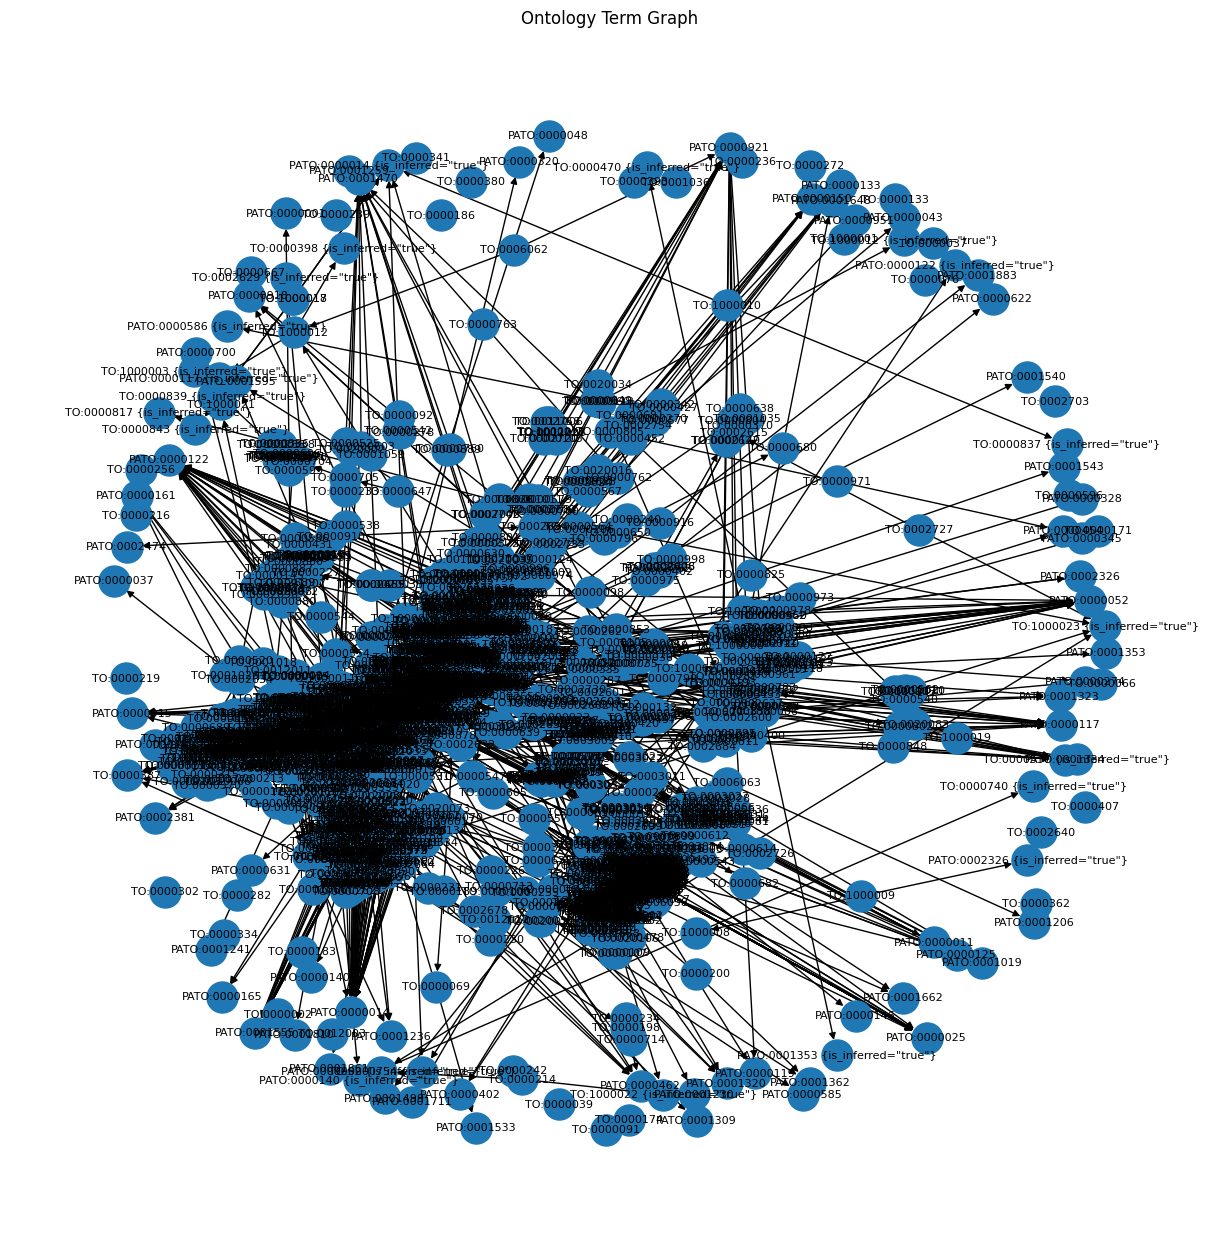

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
graph = nx.DiGraph()

# Add nodes and edges based on ontology data
for term_id, term in ontology_data.items():
    # Add the term as a node
    graph.add_node(term_id, label=term.name, definition=term.definition, is_obsolete=term.is_obsolete)
    # Add edges for 'is_a' relationships
    for parent in term.is_a:
        graph.add_edge(term_id, parent)

# Define a layout for the graph
pos = nx.spring_layout(graph, seed=42)  # Seed for reproducibility

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=8, arrowsize=10)
plt.title("Ontology Term Graph")
plt.show()

In [ ]:
import re
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import torch
import spacy
from transformers import AutoTokenizer, AutoModel
from torch.nn.functional import cosine_similarity
from tqdm.auto import tqdm

class SemanticTraitMatcher:
    def __init__(self, batch_size=32):
        # Initialize the model and tokenizer
        self.model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.batch_size = batch_size
        # Load spaCy model
        self.nlp = spacy.load('en_core_web_sm')

    def remove_stop_words(self, text: str) -> str:
        """Remove stop words using spaCy while preserving numbers and hyphens"""
        doc = self.nlp(text)
        tokens = [token.text for token in doc if not token.is_stop or token.like_num or '-' in token.text]
        return ' '.join(tokens)

    def remove_common_words(self, text: str) -> str:
        """Remove common domain-specific words like 'trait'"""
        # Define common words to remove
        common_words = ['trait', 'traits']
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in common_words]
        return ' '.join(filtered_words)

    def clean_text(self, text: str) -> str:
        """Clean and normalize text, remove stop words and common words"""
        # Basic cleaning
        text = text.lower()
        text = re.sub(r'\s*\([^)]*\)', '', text)
        text = re.sub(r'[^a-zA-Z0-9\s\-]', '', text)
        text = re.sub(r'\s*-\s*', '-', text)
        text = text.strip()

        # Remove stop words
        text = self.remove_stop_words(text)

        # Remove common domain words
        text = self.remove_common_words(text)

        # Clean up any extra spaces
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    def get_embeddings_batch(self, texts: List[str]) -> np.ndarray:
        """Get embeddings for a batch of texts"""
        encoded = self.tokenizer.batch_encode_plus(
            texts,
            padding="max_length",
            max_length=25,
            truncation=True,
            return_tensors="pt"
        )

        with torch.no_grad():
            outputs = self.model(**encoded)
            embeddings = outputs[0][:, 0, :].numpy()

        return embeddings

    def get_all_embeddings(self, texts: List[str]) -> np.ndarray:
        """Get embeddings for all texts with batching and progress bar"""
        all_embeddings = []
        num_batches = (len(texts) + self.batch_size - 1) // self.batch_size

        for i in tqdm(range(0, len(texts), self.batch_size),
                     desc="Computing embeddings",
                     total=num_batches):
            batch_texts = texts[i:i + self.batch_size]
            batch_embeddings = self.get_embeddings_batch(batch_texts)
            all_embeddings.append(batch_embeddings)

        return np.concatenate(all_embeddings, axis=0)

    def calculate_similarity_matrix(self, embeddings1: np.ndarray,
                                  embeddings2: np.ndarray) -> np.ndarray:
        """Calculate cosine similarity matrix between two sets of embeddings"""
        norm1 = np.linalg.norm(embeddings1, axis=1, keepdims=True)
        norm2 = np.linalg.norm(embeddings2, axis=1, keepdims=True)

        embeddings1_normalized = embeddings1 / norm1
        embeddings2_normalized = embeddings2 / norm2

        similarity_matrix = np.dot(embeddings1_normalized, embeddings2_normalized.T)
        return similarity_matrix

    def process_ontology_data(self, ontology_dict: Dict) -> List[Dict]:
        """Process ontology data and extract relevant information"""
        processed_data = []

        for term_id, term_obj in ontology_dict.items():
            if term_obj.is_obsolete == 'false':
                processed_data.append({
                    'term_id': term_id,
                    'original_name': term_obj.name,
                    'clean_name': self.clean_text(term_obj.name),
                    'clean_definition': self.clean_text(term_obj.definition) if term_obj.definition else "",
                    'clean_synonyms': [self.clean_text(re.sub(r'\s*\([^)]*\)', '', syn))
                                     for syn in term_obj.synonyms]
                })

        return processed_data

    def find_matches(self, trait_names: List[str], ontology_data: List[Dict],
                    similarity_threshold: float = 0.7) -> List[Dict]:
        """Find matches for all trait names efficiently"""
        # Clean trait names
        clean_traits = [self.clean_text(name) for name in trait_names]

        # Prepare lists for embeddings
        all_texts = []  # Will store all texts to get embeddings for
        text_types = []  # Will store the type of each text (name/definition/synonym)
        term_indices = []  # Will store the index of the original term

        # Add clean names, definitions, and synonyms
        for idx, term in enumerate(ontology_data):
            # Add name
            all_texts.append(term['clean_name'])
            text_types.append('name')
            term_indices.append(idx)

            # # Add definition if it exists
            # if term['clean_definition']:
            #     all_texts.append(term['clean_definition'])
            #     text_types.append('definition')
            #     term_indices.append(idx)

            # Add synonyms
            for syn in term['clean_synonyms']:
                all_texts.append(syn)
                text_types.append('synonym')
                term_indices.append(idx)

        print("Computing embeddings for trait names...")
        trait_embeddings = self.get_all_embeddings(clean_traits)

        print("Computing embeddings for ontology terms...")
        ontology_embeddings = self.get_all_embeddings(all_texts)

        print("Calculating similarity matrix...")
        similarity_matrix = self.calculate_similarity_matrix(trait_embeddings, ontology_embeddings)

        results = []
        for i, trait_name in enumerate(trait_names):
            # Find best match for this trait
            similarities = similarity_matrix[i]
            best_idx = np.argmax(similarities)
            best_score = similarities[best_idx]

            # Get original term data using the mapping
            matched_term = ontology_data[term_indices[best_idx]]
            match_type = text_types[best_idx]

            # Determine if it's an exact match
            clean_trait = clean_traits[i]
            if best_score > 0.99:  # Using 0.99 instead of 1.0 to account for floating-point precision
                if clean_trait == matched_term['clean_name']:
                    match_type = 'exact_name'
                # elif clean_trait == matched_term['clean_definition']:
                #     match_type = 'exact_definition'
                elif clean_trait in matched_term['clean_synonyms']:
                    match_type = 'exact_synonym'
            else:
                match_type = f'semantic_{match_type}'

            if best_score >= similarity_threshold:
                results.append({
                    'trait_name': trait_name,
                    'matched_id': matched_term['term_id'],
                    'matched_name': matched_term['original_name'],
                    'score': float(best_score),
                    'match_type': match_type,
                    'matched_text': all_texts[best_idx]
                })
            else:
                results.append({
                    'trait_name': trait_name,
                    'matched_id': matched_term['term_id'],
                    'matched_name': matched_term['original_name'],
                    'score': float(best_score),
                    'match_type': 'no_match',
                    'matched_text': all_texts[best_idx]
                })

        return results

def main(validation_file: str, ontology_dict: Dict) -> pd.DataFrame:
    """Main function to process trait names and find matches"""
    with open(validation_file, 'r') as f:
        trait_names = [line.strip() for line in f.readlines()[1:]]  # Skip header

    matcher = SemanticTraitMatcher()

    print("Processing ontology data...")
    processed_ontology = matcher.process_ontology_data(ontology_dict)

    print("Finding matches...")
    results = matcher.find_matches(trait_names, processed_ontology)

    return pd.DataFrame(results)

In [ ]:
def run_matcher(validation_file: str, ontology_dict: Dict) -> pd.DataFrame:
    print("Starting matching process...")
    results_df = main(validation_file, ontology_dict)

    print("\nMatching Results:")
    print("-" * 80)
    for _, row in results_df.iterrows():
        print(f"\nTrait Name: {row['trait_name']}")
        print(f"Matched ID: {row['matched_id']}")
        print(f"Matched Name: {row['matched_name']}")
        print(f"Match Score: {row['score']:.3f}")
        print(f"Match Type: {row['match_type']}")

    # Save results to CSV
    results_df.to_csv('matching_results_4.csv', index=False)
    print("\nResults saved to 'matching_results.csv'")
    return results_df

# Run with your data
validation_file = r'C:\Users\sardo\Downloads\validation_trait_names.txt'
results_df = run_matcher(validation_file, ontology_data)
results_df

Starting matching process...
Processing ontology data...
Finding matches...
Computing embeddings for trait names...


Computing embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

Computing embeddings for ontology terms...


Computing embeddings:   0%|          | 0/103 [00:00<?, ?it/s]

Calculating similarity matrix...

Matching Results:
--------------------------------------------------------------------------------

Trait Name: abiotic stress tolerance
Matched ID: TO:0000168
Matched Name: abiotic plant stress trait
Match Score: 1.000
Match Type: exact_synonym

Trait Name: auxin response
Matched ID: TO:0000163
Matched Name: auxin sensitivity
Match Score: 0.815
Match Type: semantic_name

Trait Name: cadmium content
Matched ID: TO:0006059
Matched Name: cadmium content trait
Match Score: 1.000
Match Type: exact_name

Trait Name: cereal cyst nematode resistance
Matched ID: TO:0005009
Matched Name: European corn borer resistance
Match Score: 0.789
Match Type: semantic_name

Trait Name: cytokinin accumulation
Matched ID: TO:0000167
Matched Name: cytokinin sensitivity
Match Score: 0.692
Match Type: no_match

Trait Name: disease resistance
Matched ID: TO:0000112
Matched Name: microbial disease response
Match Score: 1.000
Match Type: exact_synonym

Trait Name: fungal disease 

,trait_name,matched_id,matched_name,score,match_type,matched_text
0,abiotic stress tolerance,TO:0000168,abiotic plant stress trait,1.000000,exact_synonym,abiotic stress tolerance
1,auxin response,TO:0000163,auxin sensitivity,0.815236,semantic_name,auxin sensitivity
2,cadmium content,TO:0006059,cadmium content trait,1.000000,exact_name,cadmium content
3,cereal cyst nematode resistance,TO:0005009,European corn borer resistance,0.788961,semantic_name,european corn borer resistance
4,cytokinin accumulation,TO:0000167,cytokinin sensitivity,0.691921,no_match,cytokinin sensitivity
5,disease resistance,TO:0000112,microbial disease response,1.000000,exact_synonym,disease resistance
6,fungal disease resistance,TO:0000664,fungal blight disease resistance,0.807860,semantic_name,fungal blight disease resistance
7,Fusarium head blight disease resistance,TO:0000663,wheat fusarium head blight resistance,0.924982,semantic_name,wheat fusarium head blight resistance
8,gluten content,TO:0001136,grain protein content,0.765346,semantic_name,grain protein content
9,grain development,TO:0000653,seed growth and development trait,0.852546,semantic_name,seed growth development


In [ ]:
# with definition

In [ ]:
def run_matcher(validation_file: str, ontology_dict: Dict) -> pd.DataFrame:
    print("Starting matching process...")
    results_df = main(validation_file, ontology_dict)

    print("\nMatching Results:")
    print("-" * 80)
    for _, row in results_df.iterrows():
        print(f"\nTrait Name: {row['trait_name']}")
        print(f"Matched ID: {row['matched_id']}")
        print(f"Matched Name: {row['matched_name']}")
        print(f"Match Score: {row['score']:.3f}")
        print(f"Match Type: {row['match_type']}")

    # Save results to CSV
    results_df.to_csv('matching_results_4.csv', index=False)
    print("\nResults saved to 'matching_results.csv'")
    return results_df

# Run with your data
validation_file = r'C:\Users\sardo\Downloads\validation_trait_names.txt'
results_df = run_matcher(validation_file, ontology_data)
results_df

Starting matching process...
Processing ontology data...
Finding matches...
Computing embeddings for trait names...


Computing embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

Computing embeddings for ontology terms...


Computing embeddings:   0%|          | 0/151 [00:00<?, ?it/s]

Calculating similarity matrix...

Matching Results:
--------------------------------------------------------------------------------

Trait Name: abiotic stress tolerance
Matched ID: TO:0000168
Matched Name: abiotic plant stress trait
Match Score: 1.000
Match Type: exact_synonym

Trait Name: auxin response
Matched ID: TO:0000163
Matched Name: auxin sensitivity
Match Score: 0.866
Match Type: semantic_definition

Trait Name: cadmium content
Matched ID: TO:0006059
Matched Name: cadmium content trait
Match Score: 1.000
Match Type: exact_name

Trait Name: cereal cyst nematode resistance
Matched ID: TO:0005009
Matched Name: European corn borer resistance
Match Score: 0.789
Match Type: semantic_name

Trait Name: cytokinin accumulation
Matched ID: TO:0000167
Matched Name: cytokinin sensitivity
Match Score: 0.692
Match Type: no_match

Trait Name: disease resistance
Matched ID: TO:0000112
Matched Name: microbial disease response
Match Score: 1.000
Match Type: exact_synonym

Trait Name: fungal di

,trait_name,matched_id,matched_name,score,match_type,matched_text
0,abiotic stress tolerance,TO:0000168,abiotic plant stress trait,1.000000,exact_synonym,abiotic stress tolerance
1,auxin response,TO:0000163,auxin sensitivity,0.865699,semantic_definition,response respect application auxin
2,cadmium content,TO:0006059,cadmium content trait,1.000000,exact_name,cadmium content
3,cereal cyst nematode resistance,TO:0005009,European corn borer resistance,0.788961,semantic_name,european corn borer resistance
4,cytokinin accumulation,TO:0000167,cytokinin sensitivity,0.691921,no_match,cytokinin sensitivity
5,disease resistance,TO:0000112,microbial disease response,1.000000,exact_synonym,disease resistance
6,fungal disease resistance,TO:0000664,fungal blight disease resistance,0.807860,semantic_name,fungal blight disease resistance
7,Fusarium head blight disease resistance,TO:0000663,wheat fusarium head blight resistance,0.924982,semantic_name,wheat fusarium head blight resistance
8,gluten content,TO:0001136,grain protein content,0.765346,semantic_name,grain protein content
9,grain development,TO:0000653,seed growth and development trait,0.852546,semantic_name,seed growth development


In [ ]:
low_confidence_matchs = results_df[results_df['score'] < 0.8]
print(len(low_confidence_matchs))
low_confidence_matchs

9


,trait_name,matched_id,matched_name,score,match_type,matched_text
3,cereal cyst nematode resistance,TO:0005009,European corn borer resistance,0.788961,semantic_name,european corn borer resistance
4,cytokinin accumulation,TO:0000167,cytokinin sensitivity,0.691921,no_match,cytokinin sensitivity
8,gluten content,TO:0001136,grain protein content,0.765346,semantic_name,grain protein content
12,hybrid necrosis,TO:0002663,leaf necrosis tolerance,0.687146,no_match,necrosis tolerance
17,nitrogen use efficiency,TO:0001017,water use efficiency,0.762092,semantic_name,water use efficiency
20,pre-harvest sprouting resistance,TO:0000454,stem borer resistance,0.750204,semantic_name,stem borer resistance
23,salicylic acid content,TO:0006046,sulfur content,0.664323,no_match,sulfur content
32,tocopherol content,TO:0000289,carotene content,0.683537,no_match,carotene content
33,vernalization requirement,TO:0002662,leaf rolling tolerance,0.579402,no_match,wilting tolerance


In [ ]:
# Levenshtein Similarity
from Levenshtein import ratio as levenshtein_ratio

# Fuzzy String Matching
from fuzzywuzzy import fuzz

# Jaccard Similarity
def jaccard_similarity(s1, s2):
    set1 = set(s1.split())
    set2 = set(s2.split())
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

# Input strings
sentence1 = "viral disease resistance"
sentence2 = "viral disease response"

# Calculate similarities
levenshtein_similarity = levenshtein_ratio(sentence1, sentence2)
fuzzy_similarity = fuzz.ratio(sentence1, sentence2) / 100  # Convert to 0-1 scale
jaccard_similarity_score = jaccard_similarity(sentence1, sentence2)

# Output results
similarity_scores = {
    "Levenshtein Similarity": levenshtein_similarity,
    "Fuzzy String Matching Similarity": fuzzy_similarity,
    "Jaccard Similarity": jaccard_similarity_score
}

similarity_scores


{'Levenshtein Similarity': 0.8260869565217391,
 'Fuzzy String Matching Similarity': 0.83,
 'Jaccard Similarity': 0.5}

In [ ]:
def run_matcher(validation_file: str, ontology_dict: Dict) -> pd.DataFrame:
    print("Starting matching process...")
    results_df = main(validation_file, ontology_dict)

    print("\nMatching Results:")
    print("-" * 80)
    for _, row in results_df.iterrows():
        print(f"\nTrait Name: {row['trait_name']}")
        print(f"Matched ID: {row['matched_id']}")
        print(f"Matched Name: {row['matched_name']}")
        print(f"Match Score: {row['score']:.3f}")
        print(f"Match Type: {row['match_type']}")

    # Save results to CSV
    results_df.to_csv('matching_results_4.csv', index=False)
    print("\nResults saved to 'matching_results.csv'")
    return results_df

# Run with your data
validation_file = r'C:\Users\sardo\Downloads\validation_trait_names.txt'
results_df = run_matcher(validation_file, ontology_data)
results_df

Starting matching process...


C:\Users\sardo\miniconda3\envs\openai-env\Lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

C:\Users\sardo\miniconda3\envs\openai-env\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sardo\.cache\huggingface\hub\models--cambridgeltl--SapBERT-from-PubMedBERT-fulltext. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Processing ontology data...
Finding matches...
Computing embeddings for trait names...


Computing embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

Computing embeddings for ontology terms...


Computing embeddings:   0%|          | 0/103 [00:00<?, ?it/s]

Calculating similarity matrix...

Matching Results:
--------------------------------------------------------------------------------

Trait Name: abiotic stress tolerance
Matched ID: TO:0000168
Matched Name: abiotic plant stress trait
Match Score: 1.000
Match Type: synonym

Trait Name: auxin response
Matched ID: TO:0000163
Matched Name: auxin sensitivity
Match Score: 0.815
Match Type: semantic_name

Trait Name: cadmium content
Matched ID: TO:0006059
Matched Name: cadmium content trait
Match Score: 0.924
Match Type: semantic_name

Trait Name: cereal cyst nematode resistance
Matched ID: TO:0005009
Matched Name: European corn borer resistance
Match Score: 0.789
Match Type: semantic_name

Trait Name: cytokinin accumulation
Matched ID: TO:0000167
Matched Name: cytokinin sensitivity
Match Score: 0.692
Match Type: no_match

Trait Name: disease resistance
Matched ID: TO:0000112
Matched Name: microbial disease response
Match Score: 0.878
Match Type: semantic_synonym

Trait Name: fungal disease 

,trait_name,matched_id,matched_name,score,match_type,matched_text
0,abiotic stress tolerance,TO:0000168,abiotic plant stress trait,1.000000,synonym,NaN
1,auxin response,TO:0000163,auxin sensitivity,0.815236,semantic_name,auxin sensitivity
2,cadmium content,TO:0006059,cadmium content trait,0.923814,semantic_name,cadmium content trait
3,cereal cyst nematode resistance,TO:0005009,European corn borer resistance,0.788961,semantic_name,european corn borer resistance
4,cytokinin accumulation,TO:0000167,cytokinin sensitivity,0.691921,no_match,cytokinin sensitivity
5,disease resistance,TO:0000112,microbial disease response,0.878239,semantic_synonym,disease resistance trait
6,fungal disease resistance,TO:0000664,fungal blight disease resistance,0.807860,semantic_name,fungal blight disease resistance
7,Fusarium head blight disease resistance,TO:0000663,wheat fusarium head blight resistance,0.924982,semantic_name,wheat fusarium head blight resistance
8,gluten content,TO:0001136,grain protein content,0.765346,semantic_name,grain protein content
9,grain development,TO:0002661,seed maturation,0.770081,semantic_name,seed maturation


In [ ]:
import re
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import torch
import spacy
from transformers import AutoTokenizer, AutoModel
from torch.nn.functional import cosine_similarity
from tqdm.auto import tqdm

class SemanticTraitMatcher:
    def __init__(self, batch_size=32):
        # Initialize the model and tokenizer
        self.model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.batch_size = batch_size
        # Load spaCy model
        self.nlp = spacy.load('en_core_web_sm')

    def remove_stop_words(self, text: str) -> str:
        """Remove stop words using spaCy while preserving numbers and hyphens"""
        doc = self.nlp(text)
        tokens = [token.text for token in doc if not token.is_stop or token.like_num or '-' in token.text]
        return ' '.join(tokens)

    def remove_common_words(self, text: str) -> str:
        """Remove common domain-specific words like 'trait'"""
        # Define common words to remove
        common_words = ['trait', 'traits']
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in common_words]
        return ' '.join(filtered_words)

    def clean_text(self, text: str) -> str:
        """Clean and normalize text, then remove stop words"""
        # First normalize common variations
        text = text.lower()
        # Remove parenthetical content
        text = re.sub(r'\s*\([^)]*\)', '', text)
        # Remove everything except letters, numbers, spaces, and hyphens
        text = re.sub(r'[^a-zA-Z0-9\s\-]', '', text)
        # Normalize spaces around hyphens
        text = re.sub(r'\s*-\s*', '-', text)
        # Remove stop words
        text = self.remove_stop_words(text.strip())
        return text.strip()

    def get_embeddings_batch(self, texts: List[str]) -> np.ndarray:
        """Get embeddings for a batch of texts"""
        encoded = self.tokenizer.batch_encode_plus(
            texts,
            padding="max_length",
            max_length=25,
            truncation=True,
            return_tensors="pt"
        )

        with torch.no_grad():
            outputs = self.model(**encoded)
            embeddings = outputs[0][:, 0, :].numpy()

        return embeddings

    def get_all_embeddings(self, texts: List[str]) -> np.ndarray:
        """Get embeddings for all texts with batching and progress bar"""
        all_embeddings = []
        num_batches = (len(texts) + self.batch_size - 1) // self.batch_size

        for i in tqdm(range(0, len(texts), self.batch_size),
                     desc="Computing embeddings",
                     total=num_batches):
            batch_texts = texts[i:i + self.batch_size]
            batch_embeddings = self.get_embeddings_batch(batch_texts)
            all_embeddings.append(batch_embeddings)

        return np.concatenate(all_embeddings, axis=0)

    def calculate_similarity_matrix(self, embeddings1: np.ndarray,
                                  embeddings2: np.ndarray) -> np.ndarray:
        """Calculate cosine similarity matrix between two sets of embeddings"""
        norm1 = np.linalg.norm(embeddings1, axis=1, keepdims=True)
        norm2 = np.linalg.norm(embeddings2, axis=1, keepdims=True)

        embeddings1_normalized = embeddings1 / norm1
        embeddings2_normalized = embeddings2 / norm2

        similarity_matrix = np.dot(embeddings1_normalized, embeddings2_normalized.T)
        return similarity_matrix

    def process_ontology_data(self, ontology_dict: Dict) -> List[Dict]:
        """Process ontology data and extract relevant information"""
        processed_data = []

        for term_id, term_obj in ontology_dict.items():
            if term_obj.is_obsolete == 'false':
                clean_name = self.clean_text(term_obj.name)
                clean_def = self.clean_text(term_obj.definition) if term_obj.definition else ""
                clean_synonyms = [self.clean_text(re.sub(r'\s*\([^)]*\)', '', syn))
                                for syn in term_obj.synonyms]

                processed_data.append({
                    'term_id': term_id,
                    'original_name': term_obj.name,
                    'clean_name': clean_name,
                    'clean_definition': clean_def,
                    'clean_synonyms': clean_synonyms
                })

        return processed_data

    def find_matches(self, trait_names: List[str], ontology_data: List[Dict],
                    similarity_threshold: float = 0.7) -> List[Dict]:
        """Find matches for all trait names efficiently"""
        # Clean trait names
        clean_traits = [self.clean_text(name) for name in trait_names]

        # Create expanded ontology terms list with their sources
        ontology_terms = []
        term_sources = []
        term_mapping = []

        for term in ontology_data:
            # Add clean name
            ontology_terms.append(term['clean_name'])
            term_sources.append('name')
            term_mapping.append(term)

            # Add clean definition
            if term['clean_definition']:
                ontology_terms.append(term['clean_definition'])
                term_sources.append('definition')
                term_mapping.append(term)

            # Add clean synonyms
            for synonym in term['clean_synonyms']:
                ontology_terms.append(synonym)
                term_sources.append('synonym')
                term_mapping.append(term)

        print("Computing embeddings for trait names...")
        trait_embeddings = self.get_all_embeddings(clean_traits)

        print("Computing embeddings for ontology terms...")
        ontology_embeddings = self.get_all_embeddings(ontology_terms)

        print("Calculating similarity matrix...")
        similarity_matrix = self.calculate_similarity_matrix(trait_embeddings, ontology_embeddings)

        results = []
        for i, trait_name in enumerate(trait_names):
            clean_trait = clean_traits[i]

            # Check for exact matches first
            exact_match = None
            for term in ontology_data:
                if clean_trait == term['clean_name']:
                    exact_match = {
                        'trait_name': trait_name,
                        'matched_id': term['term_id'],
                        'matched_name': term['original_name'],
                        'score': 1.0,
                        'match_type': 'exact_name'
                    }
                    break

                if clean_trait in term['clean_synonyms']:
                    exact_match = {
                        'trait_name': trait_name,
                        'matched_id': term['term_id'],
                        'matched_name': term['original_name'],
                        'score': 1.0,
                        'match_type': 'exact_synonym'
                    }
                    break

            if exact_match:
                results.append(exact_match)
                continue

            # Find best semantic match
            similarities = similarity_matrix[i]
            best_idx = np.argmax(similarities)
            best_score = similarities[best_idx]
            best_term = term_mapping[best_idx]
            best_source = term_sources[best_idx]

            if best_score >= similarity_threshold:
                results.append({
                    'trait_name': trait_name,
                    'matched_id': best_term['term_id'],
                    'matched_name': best_term['original_name'],
                    'score': float(best_score),
                    'match_type': f'semantic_{best_source}',
                    'matched_text': ontology_terms[best_idx]
                })
            else:
                results.append({
                    'trait_name': trait_name,
                    'matched_id': best_term['term_id'],
                    'matched_name': best_term['original_name'],
                    'score': float(best_score),
                    'match_type': 'no_match',
                    'matched_text': ontology_terms[best_idx]
                })

        return results

def main(validation_file: str, ontology_dict: Dict) -> pd.DataFrame:
    """Main function to process trait names and find matches"""
    # Load validation trait names
    with open(validation_file, 'r') as f:
        trait_names = [line.strip() for line in f.readlines()[1:]]  # Skip header

    # Initialize matcher
    matcher = SemanticTraitMatcher()

    # Process ontology data
    print("Processing ontology data...")
    processed_ontology = matcher.process_ontology_data(ontology_dict)

    # Find matches for all traits
    print("Finding matches...")
    results = matcher.find_matches(trait_names, processed_ontology)

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)
    return df_results

In [ ]:
def run_matcher(validation_file: str, ontology_dict: Dict) -> pd.DataFrame:
    print("Starting matching process...")
    results_df = main(validation_file, ontology_dict)

    print("\nMatching Results:")
    print("-" * 80)
    for _, row in results_df.iterrows():
        print(f"\nTrait Name: {row['trait_name']}")
        print(f"Matched ID: {row['matched_id']}")
        print(f"Matched Name: {row['matched_name']}")
        print(f"Match Score: {row['score']:.3f}")
        print(f"Match Type: {row['match_type']}")

    # Save results to CSV
    results_df.to_csv('matching_results_4.csv', index=False)
    print("\nResults saved to 'matching_results.csv'")
    return results_df

# Run with your data
validation_file = r'C:\Users\sardo\Downloads\validation_trait_names.txt'
results_df = run_matcher(validation_file, ontology_data)
results_df

Starting matching process...
Processing ontology data...
Finding matches...
Computing embeddings for trait names...


Computing embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

Computing embeddings for ontology terms...


Computing embeddings:   0%|          | 0/151 [00:00<?, ?it/s]

Calculating similarity matrix...

Matching Results:
--------------------------------------------------------------------------------

Trait Name: abiotic stress tolerance
Matched ID: TO:0000168
Matched Name: abiotic plant stress trait
Match Score: 1.000
Match Type: exact_synonym

Trait Name: auxin response
Matched ID: TO:0000163
Matched Name: auxin sensitivity
Match Score: 0.866
Match Type: semantic_definition

Trait Name: cadmium content
Matched ID: TO:0006059
Matched Name: cadmium content trait
Match Score: 0.924
Match Type: semantic_name

Trait Name: cereal cyst nematode resistance
Matched ID: TO:0005009
Matched Name: European corn borer resistance
Match Score: 0.789
Match Type: semantic_name

Trait Name: cytokinin accumulation
Matched ID: TO:0000167
Matched Name: cytokinin sensitivity
Match Score: 0.692
Match Type: no_match

Trait Name: disease resistance
Matched ID: TO:0000112
Matched Name: microbial disease response
Match Score: 0.878
Match Type: semantic_synonym

Trait Name: fun

,trait_name,matched_id,matched_name,score,match_type,matched_text
0,abiotic stress tolerance,TO:0000168,abiotic plant stress trait,1.000000,exact_synonym,NaN
1,auxin response,TO:0000163,auxin sensitivity,0.865699,semantic_definition,response respect application auxin
2,cadmium content,TO:0006059,cadmium content trait,0.923814,semantic_name,cadmium content trait
3,cereal cyst nematode resistance,TO:0005009,European corn borer resistance,0.788961,semantic_name,european corn borer resistance
4,cytokinin accumulation,TO:0000167,cytokinin sensitivity,0.691921,no_match,cytokinin sensitivity
5,disease resistance,TO:0000112,microbial disease response,0.878239,semantic_synonym,disease resistance trait
6,fungal disease resistance,TO:0000664,fungal blight disease resistance,0.807860,semantic_name,fungal blight disease resistance
7,Fusarium head blight disease resistance,TO:0000663,wheat fusarium head blight resistance,0.924982,semantic_name,wheat fusarium head blight resistance
8,gluten content,TO:0001136,grain protein content,0.765346,semantic_name,grain protein content
9,grain development,TO:0000653,seed growth and development trait,0.790850,semantic_name,seed growth development trait


In [ ]:
perfect_matchs = results_df[results_df['score'] == 1.0]
perfect_matchs

,trait_name,matched_id,matched_name,score,match_type,matched_text
0,abiotic stress tolerance,TO:0000168,abiotic plant stress trait,1.0,exact_synonym,NaN
11,heading date,TO:0000137,days to heading,1.0,exact_synonym,NaN
13,Kernel length,TO:0000734,grain length,1.0,exact_synonym,NaN
15,kernel weight,TO:0000919,grain weight,1.0,exact_synonym,NaN
16,Kernel width,TO:0000975,grain width,1.0,exact_synonym,NaN
22,root system depth,TO:0001058,root system depth,1.0,exact_name,NaN


In [ ]:
high_confidence_matchs = results_df[(results_df['score'] >= 0.9) & (results_df['score'] < 1.0)]
high_confidence_matchs

,trait_name,matched_id,matched_name,score,match_type,matched_text
2,cadmium content,TO:0006059,cadmium content trait,0.923814,semantic_name,cadmium content trait
7,Fusarium head blight disease resistance,TO:0000663,wheat fusarium head blight resistance,0.924982,semantic_name,wheat fusarium head blight resistance
10,grain yield,TO:0000396,grain yield trait,0.940623,semantic_name,grain yield trait
18,photoperiod sensitivity,TO:0000229,photoperiod sensitivity trait,0.958672,semantic_name,photoperiod sensitivity trait
26,spike length,TO:0002768,spikelet length,0.919221,semantic_name,spikelet length
27,spikelet number per spike,TO:0000456,spikelet number,0.942683,semantic_name,spikelet number
28,stripe rust disease resistance,TO:0020054,barley stripe rust disease resistance,0.937033,semantic_name,barley stripe rust disease resistance
29,thousand-grain weight,TO:0000382,1000-grain weight,0.987823,semantic_synonym,thousand grain weight
31,tiller number per plant,TO:0000346,tiller number,0.930915,semantic_name,tiller number


In [ ]:
medium_confidence_matchs = results_df[(results_df['score'] >= 0.8) & (results_df['score'] < 0.9)]
medium_confidence_matchs

,trait_name,matched_id,matched_name,score,match_type,matched_text
1,auxin response,TO:0000163,auxin sensitivity,0.865699,semantic_definition,response respect application auxin
5,disease resistance,TO:0000112,microbial disease response,0.878239,semantic_synonym,disease resistance trait
6,fungal disease resistance,TO:0000664,fungal blight disease resistance,0.807860,semantic_name,fungal blight disease resistance
14,kernel thickness,TO:0000975,grain width,0.894184,semantic_synonym,kernel width
19,plant stress response,TO:0000401,plant growth hormone sensitivity,0.840717,semantic_synonym,plant hormone response
21,root biomass,TO:0000279,root weight,0.849975,semantic_name,root weight
24,seed vigor,TO:0000639,seed fertility,0.849239,semantic_name,seed fertility
25,septoria nodorum blotch disease resistance,TO:0020065,wheat septoria leaf blotch disease resistance,0.896151,semantic_name,wheat septoria leaf blotch disease resistance
30,Thousand-kernel weight,TO:0000919,grain weight,0.864283,semantic_synonym,kernel weight
35,wheat sharp eyespot disease resistance,TO:0020065,wheat septoria leaf blotch disease resistance,0.879942,semantic_name,wheat septoria leaf blotch disease resistance


In [ ]:
low_confidence_matchs = results_df[results_df['score'] < 0.8]
low_confidence_matchs

,trait_name,matched_id,matched_name,score,match_type,matched_text
3,cereal cyst nematode resistance,TO:0005009,European corn borer resistance,0.788961,semantic_name,european corn borer resistance
4,cytokinin accumulation,TO:0000167,cytokinin sensitivity,0.691921,no_match,cytokinin sensitivity
8,gluten content,TO:0001136,grain protein content,0.765346,semantic_name,grain protein content
9,grain development,TO:0000653,seed growth and development trait,0.790850,semantic_name,seed growth development trait
12,hybrid necrosis,TO:0002663,leaf necrosis tolerance,0.687146,no_match,necrosis tolerance
17,nitrogen use efficiency,TO:0001017,water use efficiency,0.762092,semantic_name,water use efficiency
20,pre-harvest sprouting resistance,TO:0000454,stem borer resistance,0.750204,semantic_name,stem borer resistance
23,salicylic acid content,TO:0006046,sulfur content,0.664323,no_match,sulfur content
32,tocopherol content,TO:0000289,carotene content,0.683537,no_match,carotene content
33,vernalization requirement,TO:0002662,leaf rolling tolerance,0.579402,no_match,wilting tolerance


In [ ]:
low_confidence_matchs = results_df[results_df['score'] < 0.8]
low_confidence_matchs

,trait_name,matched_id,matched_name,score,match_type,matched_text
3,cereal cyst nematode resistance,TO:0005009,European corn borer resistance,0.788961,semantic_name,european corn borer resistance
4,cytokinin accumulation,TO:0000167,cytokinin sensitivity,0.691921,no_match,cytokinin sensitivity
8,gluten content,TO:0001136,grain protein content,0.765346,semantic_name,grain protein content
12,hybrid necrosis,TO:0002663,leaf necrosis tolerance,0.687146,no_match,necrosis tolerance
17,nitrogen use efficiency,TO:0001017,water use efficiency,0.762092,semantic_name,water use efficiency
20,pre-harvest sprouting resistance,TO:0000454,stem borer resistance,0.750204,semantic_name,stem borer resistance
23,salicylic acid content,TO:0006046,sulfur content,0.664323,no_match,sulfur content
32,tocopherol content,TO:0000289,carotene content,0.683537,no_match,carotene content
33,vernalization requirement,TO:0002662,leaf rolling tolerance,0.579402,no_match,wilting tolerance


Task 4: Predict TO Mappings for Given Trait Terms
Goal: Apply your methods to predict TO mappings for a set of challengine trait terms that don't have exact matches in TO. The aim is to provide a well structured output for a manual data curation step, helping to reduce the amount of time needed for manual review.
Key Requirements:
Use validation_trait_names.txt to evaluate your model or approach.
Provide a confidence value for the mapping, where 0 means the trait term does not exist in TO (e.g. vernalization requirement), and 1 means the identified TO term is 100% correct (e.g. spike length -> TO:0002768 -> spikelet length).
Generate explanations for low-confidence predictions using an LLM.
Submit a CSV with columns: trait_term, to_id, to_term, confidence, explanation and your code.

In [ ]:
!pip install openai

In [ ]:
import os
from openai import OpenAI

# Set your API key directly in Colab
os.environ["OPENAI_API_KEY"] = "SA-"  # Replace with your actual API key

# Create the client without any additional arguments
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-4"  # or "gpt-3.5-turbo" depending on your access
)

print(chat_completion.choices[0].message.content)

This is a test.


In [ ]:
import re
from typing import Dict, List, Tuple, Optional
import pandas as pd
import numpy as np
import openai
import time
from tqdm.auto import tqdm
from fuzzywuzzy import fuzz
from dataclasses import dataclass

import os
openai.api_key = os.getenv("OPENAI_API_KEY")

from concurrent.futures import ThreadPoolExecutor
import logging
from itertools import islice
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
from openai import OpenAI
client = OpenAI()

In [ ]:
from openai import OpenAI
import pandas as pd
import numpy as np
from collections import defaultdict
from typing import Dict, List, Tuple
from tqdm import tqdm
import time
from dataclasses import dataclass
from pathlib import Path
import logging
from tenacity import retry, stop_after_attempt, wait_exponential

In [ ]:
@dataclass
class MatchResult:
    trait_term: str
    to_id: str
    to_term: str
    confidence: float
    explanation: str

class TOMapper:
    def __init__(self, api_key: str):
        """Initialize the mapper with OpenAI API key"""
        self.setup_logging()
        self.logger.info("Initializing TOMapper with OpenAI integration")
        self.client = OpenAI(api_key=api_key)

    def clean_text(self, text: str) -> str:
        """Clean and normalize text"""
        if not isinstance(text, str):
            return ""
        text = text.lower()
        text = re.sub(r'\s*\([^)]*\)', '', text)
        text = text.replace("\n", " ")
        text = re.sub(r'[^a-z0-9\s\-/]', '', text)
        return text.strip()

    def setup_logging(self):
        """Setup logging configuration"""
        self.logger = logging.getLogger('TOMapper')
        self.logger.setLevel(logging.INFO)
        handler = logging.StreamHandler()
        handler.setFormatter(logging.Formatter(
            '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
        ))
        self.logger.addHandler(handler)

    # @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def get_embedding(self, text: str) -> List[float]:
        """Get embeddings using OpenAI's API"""
        try:
            response = self.client.embeddings.create(
                model="text-embedding-3-small",
                input=[text.lower().strip()]
            )
            return response.data[0].embedding
        except Exception as e:
            self.logger.error(f"Error getting embedding: {e}")
            raise

    def get_all_embeddings(self, texts: List[str]) -> np.ndarray:
        """Get embeddings for all texts with batching and progress bar"""
        all_embeddings = []

        # Create progress bar for batches
        for text in tqdm(texts, desc="Computing embeddings"):
            try:
                # Get embedding for each text using OpenAI API
                embedding = self.get_embedding(text)
                all_embeddings.append(embedding)
            except Exception as e:
                self.logger.error(f"Error getting embedding for text '{text}': {e}")
                # Add a zero vector as fallback in case of error
                all_embeddings.append(np.zeros(3072))  # OpenAI embedding dimension #1536

        return np.array(all_embeddings)

    def calculate_similarity_matrix(self, embeddings1: np.ndarray,
                              embeddings2: np.ndarray) -> np.ndarray:
        """Calculate cosine similarity matrix between two sets of embeddings"""
        # Normalize embeddings
        norm1 = np.linalg.norm(embeddings1, axis=1, keepdims=True)
        norm2 = np.linalg.norm(embeddings2, axis=1, keepdims=True)

        embeddings1_normalized = embeddings1 / norm1
        embeddings2_normalized = embeddings2 / norm2

        # Calculate similarity matrix
        similarity_matrix = np.dot(embeddings1_normalized, embeddings2_normalized.T)
        return similarity_matrix

    # @retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=4, max=10))
    def generate_embedding_match_explanation(self, trait_term: str,
                                      matched_term: Dict,
                                      score: float) -> str:
        """Generate explanation for embedding-based matches"""
        try:
            prompt = f"""
            Task: Analyze and explain the semantic relationship between agricultural trait terms.

            Context:
            In agricultural trait ontology, the same concept may be written with numbers in different formats:
            - Numbers can be written as digits or words (e.g., "1000-grain weight" or "thousand grain weight")
            - Both formats represent the same underlying concept
            - The meaning and scientific significance remains the same regardless of notation

            Compare these terms:
            Input trait: "{trait_term}"
            Matched ontology term: "{matched_term['original_name']}"
            Ontology synonyms: {', '.join(matched_term.get('original_synonyms', []))}
            Match confidence score: {score:.3f} (on a scale of 0 to 1, where 1 indicates perfect similarity)

            Please provide a brief explanation (2-3 sentences) addressing:
            1. The conceptual relationship between the terms, including any numerical concepts they represent
            2. The strength of the match based on meaning rather than notation
            3. Any important semantic distinctions or similarities
            4. Whether the terms refer to the same agricultural trait concept

            Focus on explaining the biological or agricultural concept behind the terms.
            """

            response = self.client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": "You are a plant based agricultural expert working with Trait Ontology data. Your task is to compare terms and explain their semantic relationship."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=200,
                temperature=0.1
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            self.logger.error(f"Error generating embedding match explanation: {e}")
            return f"Semantic similarity match with confidence score: {score:.3f}"

    def process_ontology_data(self, ontology_dict: Dict) -> List[Dict]:
        """Process ontology data with original values for explanation generation"""
        processed_data = []

        for term_id, term_obj in ontology_dict.items():
            if getattr(term_obj, 'is_obsolete', 'false') == 'false':
                processed_data.append({
                    'term_id': term_id,
                    'original_name': term_obj.name,  # Add original name
                    'clean_name': self.clean_text(term_obj.name),
                    'clean_definition': self.clean_text(getattr(term_obj, 'def', '')),
                    'clean_synonyms': [self.clean_text(syn) for syn in getattr(term_obj, 'synonyms', [])],
                    'original_synonyms': getattr(term_obj, 'synonyms', [])  # Add original synonyms
                })

        return processed_data

    def find_matches(self, trait_names: List[str], ontology_data: List[Dict],
                similarity_threshold: float = 0.7) -> List[Dict]:
        """Find matches for trait terms"""
        results = []
        traits_needing_embedding = []
        trait_indices = []

        clean_traits = [self.clean_text(name) for name in trait_names]

        name_to_term = {term['clean_name']: term for term in ontology_data}
        synonym_to_term = defaultdict(list)
        for term in ontology_data:
            for synonym in term.get('clean_synonyms', []):
                synonym_to_term[synonym].append(term)

        for idx, (trait_name, clean_trait) in enumerate(zip(trait_names, clean_traits)):
            exact_match = None

            if clean_trait in name_to_term:
                term = name_to_term[clean_trait]
                exact_match = {
                    'trait_term': trait_name,
                    'to_id': term['term_id'],
                    'to_term': term['original_name'],
                    'confidence': 1.0,
                    'explanation': f"Exact match found in TO name field."
                }

            elif clean_trait in synonym_to_term:
                term = synonym_to_term[clean_trait][0]
                exact_match = {
                    'trait_term': trait_name,
                    'to_id': term['term_id'],
                    'to_term': term['original_name'],
                    'confidence': 1.0,
                    'explanation': f"Exact match found in TO synonyms."
                }

            if exact_match:
                results.append(exact_match)
            else:
                traits_needing_embedding.append(trait_name)
                trait_indices.append(idx)

        if traits_needing_embedding:
            ontology_names = [term['clean_name'] for term in ontology_data]

            trait_embeddings = self.get_all_embeddings(
                [clean_traits[i] for i in trait_indices]
            )
            ontology_embeddings = self.get_all_embeddings(ontology_names)

            similarity_matrix = self.calculate_similarity_matrix(
                trait_embeddings,
                ontology_embeddings
            )

            for batch_idx, (trait_idx, trait_name) in enumerate(zip(trait_indices, traits_needing_embedding)):
                similarities = similarity_matrix[batch_idx]
                best_idx = np.argmax(similarities)
                best_score = float(similarities[best_idx])

                # Get the matched term first
                matched_term = ontology_data[best_idx]

                # For semantic matches, use LLM for explanation
                explanation = self.generate_embedding_match_explanation(
                    trait_name,
                    matched_term,
                    best_score
                )

                match_result = {
                    'trait_term': trait_name,
                    'to_id': ontology_data[best_idx]['term_id'],
                    'to_term': ontology_data[best_idx]['original_name'],
                    'confidence': best_score,
                    'explanation': explanation
                }

                results.append(match_result)

        results.sort(key=lambda x: trait_names.index(x['trait_term']))

        return results

def main(validation_file: str, ontology_dict: Dict, api_key: str) -> pd.DataFrame:
    """Main function to process trait terms and find matches"""
    mapper = TOMapper(api_key)

    with open(validation_file, 'r') as f:
        trait_names = [line.strip() for line in f.readlines()[1:]]

    processed_ontology = mapper.process_ontology_data(ontology_dict)
    results = mapper.find_matches(trait_names, processed_ontology)

    return pd.DataFrame(results)[['trait_term', 'to_id', 'to_term', 'confidence', 'explanation']]

def run_matcher(validation_file: str,
                ontology_dict: Dict,
                api_key: str,
                output_file: str = 'to_mappings_gpt-4o.csv') -> pd.DataFrame:
    """Run the matching process with detailed output"""
    print("\nStarting TO mapping process...")
    start_time = time.time()

    try:
        results_df = main(validation_file, ontology_dict, api_key)

        # Calculate statistics
        total_terms = len(results_df)
        mapped_terms = len(results_df[results_df['confidence'] > 0])
        avg_confidence = results_df[results_df['confidence'] > 0]['confidence'].mean()

        # Print summary
        print("\nMapping Results Summary:")
        print("-" * 80)
        print(f"Total terms processed: {total_terms}")
        print(f"Terms mapped: {mapped_terms} ({mapped_terms/total_terms*100:.1f}%)")
        print(f"Terms not found in TO: {total_terms - mapped_terms}")
        print(f"Average confidence for mapped terms: {avg_confidence:.3f}")

        # Save results
        results_df.to_csv(output_file, index=False)
        print(f"\nResults saved to '{output_file}'")

    finally:
        elapsed_time = time.time() - start_time
        print(f"\nTotal execution time: {elapsed_time:.2f} seconds")

    return results_df

if __name__ == "__main__":
    from itertools import islice
    # Create a new dictionary with the first 5 entries
    # new_dict = dict(islice(ontology_data.items(), 3))
    api_key = ""
    validation_file = r'C:\Users\sardo\Downloads\validation_trait_names.txt'
    results_df = run_matcher(validation_file, ontology_data, api_key)

2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13 09:38:07,628 - TOMapper - INFO - Initializing TOMapper with OpenAI integration
2024-12-13


Starting TO mapping process...


Computing embeddings: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.60it/s]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/


Mapping Results Summary:
--------------------------------------------------------------------------------
Total terms processed: 36
Terms mapped: 36 (100.0%)
Terms not found in TO: 0
Average confidence for mapped terms: 0.276

Results saved to 'to_mappings_gpt-4o.csv'

Total execution time: 120.70 seconds


In [ ]:
results_df

,trait_term,to_id,to_term,confidence,explanation
0,abiotic stress tolerance,TO:0000168,abiotic plant stress trait,1.000000,Synonym match found
1,auxin response,TO:0000163,auxin sensitivity,0.838551,Semantic match
2,cadmium content,TO:0006059,cadmium content trait,0.837532,Semantic match
3,cereal cyst nematode resistance,TO:0000405,caseworm resistance,0.673790,No strong match found
4,cytokinin accumulation,TO:0002660,cytokinin content,0.847490,Semantic match
5,disease resistance,TO:0000129,false smut disease resistance,0.707503,Semantic match
6,fungal disease resistance,TO:0000664,fungal blight disease resistance,0.840860,Semantic match
7,Fusarium head blight disease resistance,TO:0000663,wheat fusarium head blight resistance,0.893667,Semantic match
8,gluten content,TO:0020068,beta-glucan content,0.606107,No strong match found
9,grain development,TO:0002730,grain shape,0.733331,Semantic match


In [ ]:
# Hugginface emb - cambridgeltl/SapBERT-from-PubMedBERT-fulltext

In [ ]:
import re
from typing import Dict, List, Tuple
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from torch.nn.functional import cosine_similarity
from tqdm.auto import tqdm

class SemanticTraitMatcher:
    def __init__(self, batch_size=32):
        # Initialize the model and tokenizer
        self.model_name ="cambridgeltl/SapBERT-from-PubMedBERT-fulltext" #"microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name)
        self.batch_size = batch_size

    def clean_text(self, text: str) -> str:
        """Preserve numbers, hyphens and normalize text"""
        # First normalize common variations
        text = text.lower()
        # Remove parenthetical content (like "(exact)" or "(related)")
        text = re.sub(r'\s*\([^)]*\)', '', text)
        # Remove everything except letters, numbers, spaces, and hyphens
        text = re.sub(r'[^a-zA-Z0-9\s\-]', '', text)
        # Normalize spaces (including around hyphens)
        text = re.sub(r'\s*-\s*', '-', text)
        return text.strip()

    def get_embeddings_batch(self, texts: List[str]) -> np.ndarray:
        """Get embeddings for a batch of texts"""
        encoded = self.tokenizer.batch_encode_plus(
            texts,
            padding="max_length",
            max_length=25,
            truncation=True,
            return_tensors="pt"
        )

        with torch.no_grad():
            outputs = self.model(**encoded)
            # Use CLS representation as the embedding
            embeddings = outputs[0][:, 0, :].numpy()

        return embeddings

    def get_all_embeddings(self, texts: List[str]) -> np.ndarray:
        """Get embeddings for all texts with batching and progress bar"""
        all_embeddings = []

        # Create progress bar for batches
        num_batches = (len(texts) + self.batch_size - 1) // self.batch_size

        for i in tqdm(range(0, len(texts), self.batch_size),
                     desc="Computing embeddings",
                     total=num_batches):
            batch_texts = texts[i:i + self.batch_size]
            batch_embeddings = self.get_embeddings_batch(batch_texts)
            all_embeddings.append(batch_embeddings)

        return np.concatenate(all_embeddings, axis=0)

    def calculate_similarity_matrix(self, embeddings1: np.ndarray,
                                  embeddings2: np.ndarray) -> np.ndarray:
        """Calculate cosine similarity matrix between two sets of embeddings"""
        # Normalize embeddings
        norm1 = np.linalg.norm(embeddings1, axis=1, keepdims=True)
        norm2 = np.linalg.norm(embeddings2, axis=1, keepdims=True)

        embeddings1_normalized = embeddings1 / norm1
        embeddings2_normalized = embeddings2 / norm2

        # Calculate similarity matrix
        similarity_matrix = np.dot(embeddings1_normalized, embeddings2_normalized.T)
        return similarity_matrix

    def process_ontology_data(self, ontology_dict: Dict) -> List[Dict]:
        """Process ontology data and extract relevant information"""
        processed_data = []

        for term_id, term_obj in ontology_dict.items():
            if term_obj.is_obsolete == 'false':
                clean_name = self.clean_text(term_obj.name)
                clean_def = self.clean_text(term_obj.definition)
                clean_synonyms = [self.clean_text(re.sub(r'\s*\([^)]*\)', '', syn))
                                for syn in term_obj.synonyms]

                processed_data.append({
                    'term_id': term_id,
                    'original_name': term_obj.name,
                    'clean_name': clean_name,
                    'clean_definition': clean_def,
                    'clean_synonyms': clean_synonyms
                })

        return processed_data

    def find_matches(self, trait_names: List[str], ontology_data: List[Dict],
                    similarity_threshold: float = 0.7) -> List[Dict]:
        """Find matches for all trait names efficiently"""
        # Clean trait names
        clean_traits = [self.clean_text(name) for name in trait_names]

        # Create expanded ontology terms list with their sources
        ontology_terms = []
        term_sources = []  # Track what each term represents (name/definition/synonym)
        term_mapping = []  # Map back to original ontology term

        for term in ontology_data:
            # Add clean name
            ontology_terms.append(term['clean_name'])
            term_sources.append('name')
            term_mapping.append(term)

            # Add clean definition
            # if term['clean_definition']:
            #     ontology_terms.append(term['clean_definition'])
            #     term_sources.append('definition')
            #     term_mapping.append(term)

            # Add clean synonyms
            for synonym in term['clean_synonyms']:
                ontology_terms.append(synonym)
                term_sources.append('synonym')
                term_mapping.append(term)

        print("Computing embeddings for trait names...")
        trait_embeddings = self.get_all_embeddings(clean_traits)

        print("Computing embeddings for ontology terms...")
        ontology_embeddings = self.get_all_embeddings(ontology_terms)

        print("Calculating similarity matrix...")
        similarity_matrix = self.calculate_similarity_matrix(trait_embeddings, ontology_embeddings)

        results = []
        for i, trait_name in enumerate(trait_names):
            clean_trait = clean_traits[i]

            # Check for exact matches first
            exact_match = None
            for term in ontology_data:
                if clean_trait == term['clean_name']:
                    exact_match = {
                        'trait_name': trait_name,
                        'matched_id': term['term_id'],
                        'matched_name': term['original_name'],
                        'score': 1.0,
                        'match_type': 'exact_name'
                    }
                    break

                # Check synonyms
                if clean_trait in term['clean_synonyms']:
                    exact_match = {
                        'trait_name': trait_name,
                        'matched_id': term['term_id'],
                        'matched_name': term['original_name'],
                        'score': 1.0,
                        'match_type': 'synonym'
                    }
                    break

            if exact_match:
                results.append(exact_match)
                continue


            # #debug code
            # Find best semantic match
            similarities = similarity_matrix[i]

            # # Get top matches for debugging
            # top_k = 5
            # top_indices = np.argsort(similarities)[-top_k:][::-1]

            # print(f"\nTop {top_k} matches for '{trait_name}':")
            # for idx in top_indices:
            #     term = term_mapping[idx]
            #     score = similarities[idx]
            #     source = term_sources[idx]
            #     print(f"Term: {term['original_name']:<30} Score: {score:.4f}")
            #     print(f"Matched via: {source}")
            #     print(f"Matched text: '{ontology_terms[idx]}'")
            #     print("---")
            # # #debug code


            # Use the best match
            best_idx = np.argmax(similarities)
            best_score = similarities[best_idx]
            best_term = term_mapping[best_idx]
            best_source = term_sources[best_idx]

            if best_score >= similarity_threshold:
                results.append({
                    'trait_name': trait_name,
                    'matched_id': best_term['term_id'],
                    'matched_name': best_term['original_name'],
                    'score': float(best_score),
                    'match_type': f'semantic_{best_source}',
                    'matched_text': ontology_terms[best_idx]
                })
            else:
                results.append({
                    'trait_name': trait_name,
                    'matched_id': best_term['term_id'],
                    'matched_name': best_term['original_name'],
                    'score': float(best_score),
                    'match_type': 'no_match',
                    'matched_text': ontology_terms[best_idx]
                })

        return results

def main(validation_file: str, ontology_dict: Dict) -> pd.DataFrame:
    """Main function to process trait names and find matches"""
    # Load validation trait names
    with open(validation_file, 'r') as f:
        trait_names = [line.strip() for line in f.readlines()[1:]]  # Skip header

    # Initialize matcher
    matcher = SemanticTraitMatcher()

    # Process ontology data
    print("Processing ontology data...")
    processed_ontology = matcher.process_ontology_data(ontology_dict)

    # Find matches for all traits
    print("Finding matches...")
    results = matcher.find_matches(trait_names, processed_ontology)

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)
    return df_results

In [ ]:
def run_matcher(validation_file: str, ontology_dict: Dict) -> pd.DataFrame:
    print("Starting matching process...")
    results_df = main(validation_file, ontology_dict)

    print("\nMatching Results:")
    print("-" * 80)
    for _, row in results_df.iterrows():
        print(f"\nTrait Name: {row['trait_name']}")
        print(f"Matched ID: {row['matched_id']}")
        print(f"Matched Name: {row['matched_name']}")
        print(f"Match Score: {row['score']:.3f}")
        print(f"Match Type: {row['match_type']}")

    # Save results to CSV
    results_df.to_csv('matching_results_4.csv', index=False)
    print("\nResults saved to 'matching_results.csv'")
    return results_df

# Run with your data
validation_file = "validation_trait_names.txt"
results_df = run_matcher(validation_file, ontology_data)
results_df


Starting matching process...


Processing matches:   0%|          | 0/36 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 404 Not Found"


Computing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/52 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 404 Not Found"


Computing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/52 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 404 Not Found"


Computing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/52 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 404 Not Found"


Computing embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/52 [00:00<?, ?it/s]

KeyboardInterrupt: 